# Project 3: Subreddit Classification
# Project Overview

**Data science process demonstrated:**
- Webscraping (Request) and APIs 
- Natural Language Processing (Naive Bayes, Stemming/Lemmatization, CounterVectorization, TfidfVectorizer)
- Regular Expression
- Confusion Matrix
- Logistic Regression Classifier
- Pipeline and Gridsearch

# Problem Statement

The goal of the project is to use predictive models to predict which subreddit does a post came from and to identify words that can help to differentiate 2 chosen subreddits.
 
Questions that we need to answer:
- Which words will most differentiate our two chosen subreddits?
- How can we use predictive modeling to best predict which subreddit a post came from?

To answer these questions, we have to build an appropriate natural language processing(NLP) or logistic regression model, which classifies a post with missing labels using top predictive words trained on it.

Success of the model will be evaluated based on classification accuracy. Best model will have the least difference in classification accuracy between the training and test dataset. This is to ensure no overfitting and model can still perform upon applying to unseen data. The model is then further interpreted using confusion matrix parameters.

Our stakeholders are data scientists in Reddit whereby they experience a server technical problem and the labels of posts were lost. This server issue can cause users to lose track of their posts or posts being end up at the wrong subreddit. This might sound like a trivial mistake but users can lose confidence in Reddit. Advertising revenue can be lost because the advertisments ended up at the wrong subreddits. Data Scientists in Reddit can make use of my Production model to classify post back to their respective subreddit within a short time frame, automatically without reviewing the content manually by human. This model evaluation is not only a method to address this missing post label issue, its techniques also have application beyond the scope of this project. Example, an email service wants to detect spam emails.

The subreddits selected were [r/PS5](urlhttps://www.reddit.com/r/PS5/) and [r/XboxSeriesX](urlhttps://www.reddit.com/r/XboxSeriesX). Both are home video gaming consoles, going to be luanched this November at the same price. The 2 subreddits are similar in many ways and often being compared against. Their key differences will be manufacturer - Playstation is by Sony and Xbox is developed by Microsoft.


# Executive Summary

This project extract posts from Reddit's API and evaluates the number of times each word appears in the 2 chosen subreddits. The top frequently appearing words identified during initial exploratory data analysis showed that product names, manufacturer names are the best words to differentiate them. These findings helped us built an appropriate predictive model (Logistic Regression with CountVectorizer) which is able to classify a post without label, back to its respective subreddit. We evaluate the success by choosing a model with lowest difference in classification accuracy, between the test and training dataset. By interpreting the confusion metric, we can tell how each word predicts the subreddit classification.

Paired with the knowledge of how these words associate with the subreddits, Data Scientiests in Reddit can make use of the model to trace posts with missing post labels back to their respective subreddit. This can prevent lost of Reddit users and advertising customers, caused by the server system glitch and therefore will be a good solution for Reddit's Data Scientists who are 


### Contents:
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Web Scraping and Data Acquisition](#Web-Scraping-and-Data-Acquisition)
- [Data Cleaning and Exploratory Data Analysis](#Data-Cleaning-and-Exploratory-Data-Analysis)
- [Preprocessing](#Preprocessing)
- [Modeling](#Modeling)
- [Modeling Evaluation](#Modeling-Evaluation)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [3]:
# Import libraries

# read files
# use os and glob to always select the latest json file
import glob 
import os

# Maths
import pandas as pd
import numpy as np

# Web scraping
import requests
import json
import time, warnings
import datetime as dt

# nlp, cleaning
import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string # for punctuation removal
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import nltk
from nltk.corpus import stopwords

# Modeling
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import roc_auc_score

# For visuals
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as venn2
%matplotlib inline
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud

# display link
from IPython.core.display import display, HTML
from IPython.display import Image

# display data
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 500
pd.set_option('display.max_colwidth', None) # set full view to inspect text

# Web Scraping and Data Acquisition

- There are many ways to scrape data from web such as psaw, praw, BeautifulSoup, pushshift api and scrapy.
- Since the requirement for this project is to use request to gather json file, I decided that the best way to meet this expectation is to modify the function given during tutorial 4.06 Api Integration and Consumption.
- First, I will need to generate a request for quick data inspect. 
- This is to help understand the steps of scraping and have a feel of all the data extracted from the subreddit.

In [2]:
# Step 1: Brief inpection for 1 request. This is to plan out what function/method to extract all 1000 posts for each 
# subreddit.

url = 'https://www.reddit.com/r/XboxSeriesX.json'
res = requests.get(url, headers={'User-agent': 'Pony Inc 1.0'})

# check for errors
if res.status_code != 200:
    print('Status error', res.status_code)

# Forming of a dictionary
reddit_dict = res.json()

# extract data
posts = [p['data'] for p in reddit_dict['data']['children']]

# form dataframe for easier reading
pd.DataFrame(posts).head(1)

approved_at_utc    subreddit  \
0            None  XboxSeriesX   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               selftext  \
0  &amp;#x200B;\n\nhttps://preview.redd.it/du20aqzqedp51.jpg?width=1920&amp;format=pjpg&amp;auto=webp&amp;s=db5193c62a37d86f6a72dbe5bf1db4f064bb32f1\n\nHey everybody,\n\nIn celebration of Bethesda joining the Xbox family, we’d like to take this opportunity to acknowledge the awesome communities that’ll be joining the Xbox family, too:\n\n* [r/BethesdaSoftworks](https://www.reddit.com/r/BethesdaSoftworks/): A fan-made community dedicated to all games, mods, and projects related to the game publisher Bethesda Softworks and its subsidiary developer studios.\n* [r/dishonored](https://www.reddit.com/r/dishonored/): Subreddit for the Arkane Studios video games Dishonored, Dishonored 2, and Dishonored: Death of the Outsider™.\n* [r/Doom](https://www.reddit.com/r/Doom/): Everything related to the hit action-horror series DOOM, by id software.\n* [r/ElderScrolls](https://www.reddit.com/r/ElderScrolls/): A community dedicated the Elder Scrolls franchise, developed by Bethesda Game Studios.\n* [r/elderscrollsonline](https://www.reddit.com/r/elderscrollsonline/): A Reddit community dedicated to The Elder Scrolls Online, an MMO developed by Zenimax Online.\n* [r/Fallout](https://www.reddit.com/r/Fallout/): A state-of-the-art su

**Summary of examining a request dataframe**

- Based on Readme, Reddit Api has a cap at 1,000 posts for each subreddit.
- Per request will return 25 posts. Hence I need to loop at least 40 times to obtain 1000 posts. 
- Examined which are the useful columns. 'title' is the most clean, short text and good info. 'selftext' contains lots of useful content but less clean and lots of missing entries. Missing selftext is due author attached images or youtube videos instead of typing text.
- 'selftext' and 'selftext.html' are the same. Choose selftext.
- Decided not to extract comments since we have title that can supplement the insuficient selftext entries.
- 'name', 'id' could be the identity name of json file.
- 'author_fullname', 'author', address author's identity. Just need to choose 1 among these.
- 'up' and 'score' is the same. Choose 1 between them
- Ignore colours, look and feel related columns.
- Choose between 'created' or 'created_UTC' for date creation
- 'flair' tags did contain a low quantity amount of useful tags but it is either mainly flooded with emojis or its empty 
- Mostly of the data are 'None's in other columns
- 'distinguish' columns has very little entries, hence decided to abandon it

Finally, I decided to scrap 'title', 'author', 'selftext', 'score', 'upvote_ratio', 'num_comments' and create a column on date

Steps to be taken:
- Create iteration function to scrape 1000 posts, each 25 posts/request, for above columns of interest
- Extract json files
- Convert to dataframe
- Drop duplicates (Side note! During data cleaning, I had found out that there are duplicates hence i revert back to this step to add more iterations. By doing this, I found out that iterating more times does not give you more uniques, but more duplicates. Hence, i decided to implement drop duplicates in my functions so that I can directly know how many uniques I am having. I also choose 50 iterations instead of 40. This is to make sure I scrape as much as I can since I dont need to worry about duplicates, as there were removed directly during web scraping, in my function.)
- Apply function for the 2 chosen subreddits
- json file sanity check. I ensure there are 25 posts in last json file extracted by my web scraping fuction
- Output csv files for both subreddits

In [3]:
# modified from reddit-api workbook from 4.06 api integration and consumption lesson

def webscrape_subreddit(subreddit):
    
    posts = []
    after = None

    for a in range(50):  # iterate 50 times(attempt to scrape 1250 posts)
        
        url = f'https://www.reddit.com/r/{subreddit}/new.json' # download posts sorted by new
        
        if after == None:
            current_url = url
        else:
            current_url = url + '?after=' + after

        # send request to url
        res = requests.get(current_url, headers={'User-agent': 'Pony Inc 1.0'})

        # check for errors
        if res.status_code != 200:
            print('Status error', res.status_code)
            break
            
        # generate a random sleep duration to look more 'natural'
        sleep_duration = np.random.randint(2,6)
        time.sleep(sleep_duration)
    
        # get posts and add to [posts]
        current_dict = res.json()
        current_posts = [p['data'] for p in current_dict['data']['children']]
        posts.extend(current_posts)
        
        # Output JSON file for each request. Use timestamp to separate each request file 
        timestamp = dt.datetime.now()
        timestamp = timestamp.strftime(" %Y_%m_%d %H_%M_%S")
        with open(f'../json_files/{subreddit}/posts_{subreddit}_{timestamp}.json', 'w') as outfile:
            json.dump(current_dict, outfile)

        # get tag of last post on the page
        after = current_dict['data']['after']

        
    # create dataframe to extract useful columns

    df_post = pd.DataFrame(posts)
    df_post = df_post[['title','author','created', 'selftext', 'score', 'upvote_ratio', 'num_comments']]
    df_post['date_created'] = pd.to_datetime(df_post['created'], unit = 's') #create new date column
    # remove column that is used to create date
    df_post = df_post[['title','author','selftext', 'score', 'upvote_ratio', 'num_comments', 'date_created']]

    # check whether all posts are added to df_post
    df_post.shape[0] == len(posts)

    # Investigate duplicates
    print("There are", df_post.duplicated(subset='title').sum(), "number of duplicate posts")
    df_post = df_post.drop_duplicates(subset='title') #drop the duplicates

    # print number of posts saved
    print(f'After removing the duplicates, a total of {len(df_post)} posts were downloaded.')

    return df_post

In [4]:
%%time
# Call function for XboxSeriesX dataframe
df_xboxseriesx = webscrape_subreddit('XboxSeriesX')
df_xboxseriesx.head()

There are 249 number of duplicate posts
After removing the duplicates, a total of 999 posts were downloaded.
Wall time: 3min 46s


title  \
0      Do you think Microsoft or 3rd party retailers will have more pre-order available before November 10th?   
1                   Sharing GPU and making "leech" account use 1$ promo (main accouont already used 1$ promo)   
2          BC titles on XSX see great FPS enhancements...how much better will FPS of XBone S games be on XSS?   
3                                           EA Play joins game pass on November 10th (December for GP for PC)   
4  Something not really talked about on the subject of the Bethesda acquisition which could potentially suck.   

                 author  \
0  CompletelyInadequate   
1            staypunk89   
2            sgurschick   
3           Headbomb399   
4            CGMMonster   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            selftext  \
0                                                                                                                            Like how PlayStation has had more chances to pre order as time passes by, do you think Xbox Series X will share the same fate? I want to get my hands on one so bad and hopefully on release day or somewhere near it! Thanks everyone, I'm hyped for next gen, I can't believe we still have all of October to wait still ahh!!!!\n\ntl;dr - title says it all, do you think Microsoft or 3rd party retailers will have more pre-order available before November 10th?   
1                                                                                                                                                                                  Hello all,\n\nMe and my brother have shared account. I've already used the 1$ promo for GPU 2 years ago, and now it expired.\n\nI was wondering if it was possible for me to buy 3years worth of gold, and then make my brother's account (leech) to redeem the 1$ promo to turn the 3 years of gold into GPU.  \n\n\nWould it be possible, and is GPU shared between linked profiles ?\n\n&amp;#x200B;\n\nthanks   
2                                                                                                                                                                                                                                                                                                                                                                   BC titles on XSX see great FPS enhancements...how much better will FPS of XBone S games be on XSS?\n\nWill we see 50% - 100% FPS gains? Or are most Xbox One S games locked at 30 FPS and we will therefore get no gains on XSS?   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
4  So we know Microsoft has said that their main competition will be Google and Amazon. With that being said they will be looking to acquire more studios.\n\nBut what about the opposite? What studios will be lost/exclusive to Amazon and Google? That sounds terrible losing more multiplatform titles to a platform I want nothing to really do w

In [5]:
%%time
# Call function for PS5 dataframe
df_ps5 = webscrape_subreddit('PS5')
df_ps5.head()

There are 302 number of duplicate posts
After removing the duplicates, a total of 927 posts were downloaded.
Wall time: 3min 27s


title  \
0        25 years ago today, PlayStation launched in the UK!   
1                            Ubisoft next-gen upgrade policy   
2  44 Days of Appreciation: Favorite Playstation Game Manual   
3                          [Video] PS5 Upcoming Indie Titles   
4         Sony not supporting bluetooth headphones is insane   

                author  \
0              hybroid   
1          Nagolnerraw   
2   MetroidPrimeMaster   
3              Monetep   
4  _A-L-E-X-A-N-D-E-R_   

                                                                                                                                                                                                                                      selftext  \
0                                                                                                                                                                                                                                                
1                                                                                                                                                                                                                                                
2                                                                                                                                                                                               Mine: FF7\n\nI thought the pictures were cool.   
3                                                                                                                                                                                                                                                
4  For a 500$ console I would expext sony to allow us to use any bluetooth headphones that we want, especilly with everyone using airpods or buds today. Having to pay extra 100$ for hardware that we don't need reminds me of Apple culture.   

   score  upvote_ratio  num_comments        date_created  
0     26          0.88             6 2020-09-29 20:57:41  
1     80          0.95            66 2020-09-29 20:27:50  
2      0          0.38            12 2020-09-29 20:25:22  
3      3          0.58             4 2020-09-29 20:06:04  
4      0          0.27            43 2020-09-29 19:21:58

In [6]:
# json sanity check to make sure no error during data extraction for XboxSeries
# use os and glob to always select the latest json file to pull for sanity check
# Importing of json files named by timestamp, after multiple runs

list_of_files = glob.glob('../json_files/xboxseriesx/*.json') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

# load a json file using open(), json.load(). Check the number of posts in 1 request
f = open(latest_file,)

# returns JSON object as a dictionary 
json_xboxseriesx = json.load(f)
print("Sanity check shows the latest request containing", len(json_xboxseriesx['data']['children']), "posts")

Sanity check shows the latest request containing 25 posts


In [7]:
# json sanity check to make sure no missing data for PS5
# use import os and import glob to always select the latest json file to pull for sanity check
# Importing of json files named by timestamp, after multiple runs

list_of_files = glob.glob('../json_files/ps5/*.json') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)

# load a json file using open(), json.load(). Check the number of posts in 1 request
f = open(latest_file,)

# returns JSON object as a dictionary 
json_ps5 = json.load(f)
print("Sanity check shows the latest request containing", len(json_ps5['data']['children']), "posts")

Sanity check shows the latest request containing 25 posts


In [8]:
# Output XboxSeriesX and PS5 dataframe posts to csv
df_xboxseriesx.to_csv('../data/xboxseriesx_posts1.csv', index = False)
df_ps5.to_csv('../data/ps5_posts1.csv', index = False)

# Data Cleaning and Exploratory Data Analysis
## Data Import
A copy of the csv files created during web scraping is made and save under a different filename. From now onwards, I will only load these 2 subreddit files for analysis. This is to ensure everytime when I have to re-run this entire report, my analysis wasnt overwritten by new posts and I have consistent data. Possible incoming new data can be from:

1) any new posts into subreddit\
2) when someone delete a post\
3) when a comment is added\
4) new upvote scoring

These new information can change my model results whenever I re-run this entire report. Hence I need to ensure dataset is not dynamic to avoid impact to my existing analysis/model.

Loading a csv at this point can also help to save time as I dont need to spend time to run web scraping when resetting my analysis. I can just load the data from this step onwards if resetting is needed.

In [4]:
# load csvs so that i dont need to rerun webscraping everytime i need to reset my code.
# You will notice files are of different names as my output csv at web scraping step. This is to ensure dataset consistency
df_xboxseriesx = pd.read_csv('../data/xboxseriesx_posts.csv')
df_ps5 = pd.read_csv('../data/ps5_posts.csv')

## Data Inspect

In [5]:
print("There are", len(df_xboxseriesx), "XboxSeriesX posts")
print("There are", df_xboxseriesx.shape[1], "columns in XboxSeriesX posts")
print("There are", len(df_ps5), "PS5 posts")
print("There are", df_ps5.shape[1], "columns in PS5 posts")
print("The number of rows for both subreddits is considerably near.\
 There shall not be any unbalance classification issue during modeling")

There are 976 XboxSeriesX posts
There are 7 columns in XboxSeriesX posts
There are 930 PS5 posts
There are 7 columns in PS5 posts
The number of rows for both subreddits is considerably near. There shall not be any unbalance classification issue during modeling


In [6]:
df_xboxseriesx.info()
# selftext has most NaN. Which is 30%. 
# all datatypes are correct but we need to change all texts to string so we can process the text data later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         976 non-null    object 
 1   author        976 non-null    object 
 2   selftext      683 non-null    object 
 3   score         976 non-null    int64  
 4   upvote_ratio  976 non-null    float64
 5   num_comments  976 non-null    int64  
 6   date_created  976 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 53.5+ KB


In [7]:
df_ps5.info()
# selftext has most NaN. Which is 23.5%. 
# all datatypes are correct but we need to change all texts to string so we can process the text data later

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         930 non-null    object 
 1   author        930 non-null    object 
 2   selftext      711 non-null    object 
 3   score         930 non-null    int64  
 4   upvote_ratio  930 non-null    float64
 5   num_comments  930 non-null    int64  
 6   date_created  930 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 51.0+ KB


We see selftext have many missing entries. This is probably because not all posts on reddit have body text (i.e. they just have titles and links). Later we need to clear this null value issue so that we can analyse the dataframe. % null selftext difference between the 2 subreddit is 6.5%. Meaning there is no major difference in posting behaviour of selftext, for both subreddits

There are slightly more text posts under PS5 subreddit. 6.47% More people post text under r/PS5


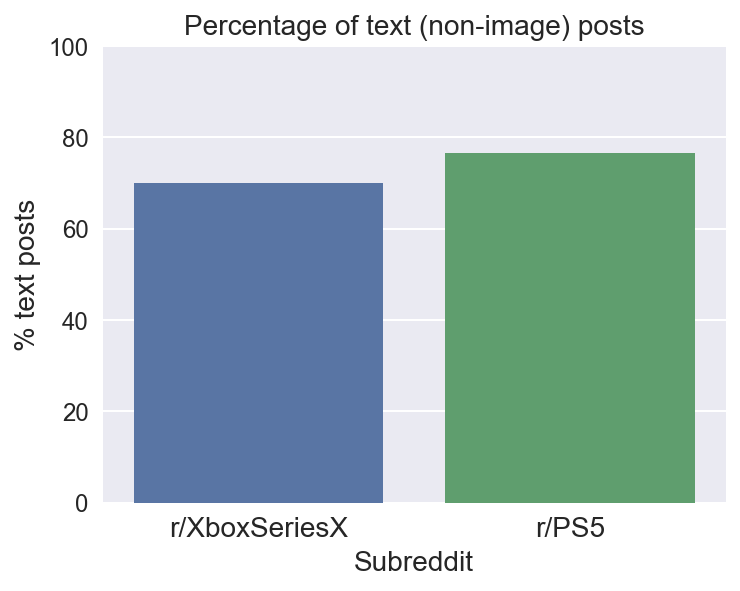

In [8]:
# plot a chart to see the % of selftext in a subreddit
df_xboxseriesx_text_posts = (df_xboxseriesx.notnull().sum()['selftext']/df_xboxseriesx.shape[0]) * 100
df_ps5_text_posts = (df_ps5.notnull().sum()['selftext']/df_ps5.shape[0]) * 100

print(f"There are slightly more text posts under PS5 subreddit. \
{round((df_ps5_text_posts - df_xboxseriesx_text_posts),2)}% More people post text under r/PS5")

plt.figure(figsize = (5,4))
sns.barplot(y = [df_xboxseriesx_text_posts, df_ps5_text_posts], x = ['r/XboxSeriesX','r/PS5'])
plt.title('Percentage of text (non-image) posts', fontsize=14)
plt.ylim(0,100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.xlabel("Subreddit", fontsize=14)
plt.ylabel("% text posts", fontsize=14);

In [9]:
# inspect text eg title and selftext columns
df_xboxseriesx.head(50)
# need to clean title and selftext to remove emoji, &amp, \n, ~, hyperlinks, #x200B

title  \
0                                                                                                                            "Random" fan decided to make this awesome XGP trailer. Credit to : Vincenzo Fayez channel   
1                                                                                                                                                                       Is the taco bell deal available in my country?   
2                                                                                                                                                                State of mouse and keyboard support on Xbox consoles?   
3                                                                                                 I don't know if anyone has posted this yet, but Amazon has the release date for Halo Infinite as December 31st, 2021   
4                                                                                                                                                                                          TV upgrade for the Series X   
5                                                                                                                     Does anyone know if xbox one controller battery packs will work in the new Series x controllers?   
6                                                                                                                                                                                How is this for a budget HDMI 2.1 T.V   
7                                                                                                                                                    Switching to console after 8 years of pc gaming with GOD tier PCs   
8                                                                                                                         I really like that you can add games to play later on the GP app even without a subscription   
9                                                                                                                                                                                            USB 7.1 surround support?   
10                                                                                                                                                                         Does it ship on the 10th or arrive by then?   
11                                                                                                                          Bought an Xbox One X instead of an Xbox Series X? You probably only have yourself to blame   
12                                                                                                                                                  i need something like this for the series x i preordered any link?   
13                                                                                                                                                                          Will Warzone on series X have fov slider ?   
14                                                                                                                                                                          Beyond Light free to Game Pass subscribers   
15  OMG I won the Xbox. I seriously can't believe it. I bought like over $40 in medium drinks and been waking up at 3am entering codes thinking I'll never win... and i won on my 2nd to last cup. I'm still in shock!   
16                                                                                                                                                                                         Godfall. Yeah, not for you.   
17                                                                                                                                                                             New to Xbox this new gen, what to play?   
18                                                                 

In [10]:
# inspect text eg title and selftext columns
df_ps5.head(50)
# need to remove emoji, &amp, \n, ~, hyperlinks, #x200B

title  \
0                                                                                                                                                      We have to stop   
1                                                                                                                                            PlayStation design studio   
2                                                                                                                      Will i be able to download my ps4 games on ps5?   
3                                                                                   Can we connect my PS4’s extended storage (hard drive) to PS5 and access the games?   
4                                                                                                                                 PlayStation plus collection question   
5                                                                                                          It’s time for PlayStation Studios to try new things for PS5   
6                                                                                                                    Question about 3 PS5 systems and account sharing.   
7                                                                                                                               Which Headset are you Guys Going With?   
8                                                                                                                           I'm just as excited for the 4K Uhd player.   
9                                                  Will the current PSVR Headset improve with the PS5 and will we finally be able to get longer cables for the camera?   
10                                                                                                                                          will black ps5 be a thing?   
11                                                                                                                Has anyone else forgotten that October even existed?   
12                                                                      Will The Upcoming Astro’s Playroom Have The Option To Delete It Unlike The Current One On PS4?   
13                                                           How is it possible for a console is being distributed world wide and not even a single leak is out there.   
14                                                                                   How will those of you getting the console on the 19th handle the week difference?   
15                                                                                                          When do you guys think we will get a UI revel for the PS5?   
16                                                                                            What do we know about the “Top 100” games that will be upscaled for PS5?   
17                                                                                                       I hope PS5 will allow us to do this.(regarding save scumming)   
18                                                                                                               Closer look and original source of DualSense teardown   
19                                                                                                                                          Ps5 digital games transfer   
20                                                                                                                             How the PS5 would fit my current setup.   
21                                                                                                                                            Got my holiday booked in   
22                                                                                                                                         PS5 checkerboard rendering?   
23                                                                               

In [11]:
# check for cross-post between XboxSeriesX and PS5.
common_posts = df_ps5.title.isin(df_xboxseriesx.title) & df_xboxseriesx.title.isin(df_ps5.title)
common_posts.value_counts()
# no cross-post observed

False    976
Name: title, dtype: int64

**Summary of data inspection results:**

- We confirmed that difference in number of rows between the 2 subreddits is 2.4%, there is no unbalance classification issue. 
- There is no cross-post
- % notnull selftext is similar between the 2 subreddits. Meaning behaviour of posting texted selftext between both subreddits is similiar.

Cleaning steps identified:
- Change text data types to string, else will have problem running cleaning function later. 
- Subsequently, replace 'nan' with '  ', so that 'nan' will not be confused with genuine text
- Apply regex function to clear emojis, http links, signs, random numbers and signs for text columns
- repeat or add new cleaning steps if needed

## Data Cleaning


### Check for duplicates
There shouldnt be any duplicates as it was cleared during web scraping function

In [12]:
# check for duplicates.
print("There are", df_xboxseriesx.duplicated().sum(), "duplicates for r/XboxSeriesX")
print("There are", df_ps5.duplicated().sum(), "duplicates for r/PS5")
# There are no duplicates

There are 0 duplicates for r/XboxSeriesX
There are 0 duplicates for r/PS5


### Change object data type to string, impute missing selftext with '  '. 
- Null values will automaticaly change to 'nan' during conversion to string. 
- 'nan's were then replaced by '  ', so that it will not be confused with genuine text post

In [13]:
# Convert text data to string for easy cleaning
for col in ['selftext', 'author', 'title']:
    df_ps5[col] = df_ps5[col].astype(str)
    df_xboxseriesx[col] = df_xboxseriesx[col].astype(str)

In [14]:
# replace 'nan' in selftext with ' '

df_ps5['selftext'].replace({'nan': ''}, inplace=True)
df_xboxseriesx['selftext'].replace({'nan': ''}, inplace=True)

In [15]:
# check! words exist as blank in XboxSeries
df_xboxseriesx[(df_xboxseriesx.selftext=='')][['selftext']].head()

selftext
0          
3          
5          
10         
11

In [16]:
# Check! words exist as blank in XboxSeries
df_ps5[(df_ps5.selftext=='')][['selftext']].head()

selftext
25         
26         
36         
59         
70

### Clean text data
-  clear emoji, http links, signs, random numbers and signs for both subreddits using Regex in a function (Round 1)

In [17]:
# import string punctuation for cleaning using regex before apply function
punctuation = string.punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [18]:
# Round 1 cleaning

# function to clean data using regex library
# remove special signs and punctuation marks

# function to clean subreddit
def process_subreddit(subreddit):
    # Remove words with 2 or fewer letters. Purposefully placed at the top to remove short words like i, me, do etc
    subreddit = re.sub(r'\b\w{1,2}\b', '', subreddit)
    
    # Remove emoji
    subreddit = re.sub(r'[^\x00-\x7F]+', '', subreddit)
    
    # Remove HTML special entities (e.g. &amp;)
    subreddit = re.sub(r'\&\w*;', '', subreddit)
    
    #Convert @username to AT_USER
    subreddit = re.sub('@[^\s]+','',subreddit)
    
    # Remove tickers
    subreddit = re.sub(r'\$\w*', '', subreddit)
    subreddit = re.sub(r'\£\w*', '', subreddit)
    
    # To lowercase
    subreddit = subreddit.lower()
    
    # Remove hyperlinks
    subreddit = re.sub(r'https?:\/\/.*\/\w*', '', subreddit)
    
    # Remove whitespace (including new line characters)
    subreddit = re.sub(r'\s\s+', ' ', subreddit)
    
    # Remove Punctuation and split 's, 't, 've with a space for filter
    subreddit = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', subreddit)
    
    # remove Standalone numbers but keep numbers if it is integrated with words eg ps4, ps5, 2K21, 60Hz
    subreddit = re.sub(r'\s*(?<!\B|-)\d+(?!\B|-)\s*', ' ', subreddit)
    
    # remove quotes
    subreddit = re.sub(r'[\"\',]', '', subreddit)  
    
    # Remove single space remaining at the front of the subreddit.
    subreddit = subreddit.lstrip(' ')

    
    return subreddit

In [19]:
# apply cleaning function to XboxSeriesX
df_xboxseriesx['selftext'] = df_xboxseriesx['selftext'].apply(process_subreddit)
df_xboxseriesx['title'] = df_xboxseriesx['title'].apply(process_subreddit)

# apply cleaning function for ps5
df_ps5['selftext'] = df_ps5['selftext'].apply(process_subreddit)
df_ps5['title'] = df_ps5['title'].apply(process_subreddit)

In [20]:
# Check! r/XboxSeriesX after Round 1 cleaning
df_xboxseriesx.head(50)
# Notice \n and \ remaining in the text posts

title  \
0                                                                                        random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel   
1                                                                                                                                     the taco bell deal available country    
2                                                                                                                           state mouse and keyboard support xbox consoles    
3                                                                    don  know anyone has posted this yet  but amazon has the release date for halo infinite december 31st    
4                                                                                                                                                   upgrade for the series    
5                                                                                  does anyone know xbox one controller battery packs will work the new series controllers    
6                                                                                                                                              how this for budget hdmi       
7                                                                                                                    switching console after years gaming with god tier pcs   
8                                                                                           really like that you can add games play later the app even without subscription   
9                                                                                                                                                   usb   surround support    
10                                                                                                                                          does ship the 10th arrive then    
11                                                                                              bought xbox one instead xbox series   you probably only have yourself blame   
12                                                                                                             need something like this for the series preordered any link    
13                                                                                                                                    will warzone series have fov slider     
14                                                                                                                                  beyond light free game pass subscribers   
15  omg won the xbox  seriously can  believe   bought like over medium drinks and been waking 3am entering codes thinking   never win  and won 2nd last cup    still shock    
16                                                                                                                                              godfall  yeah  not for you    
17                                                                                                                                        new xbox this new gen  what play    
18                                                                                                                                        xbox series competition australia   
19                            reposting few months later the sub tripled size but this very interesting  double fine has second project which years the works  and its new    
20                                                                                                                                                microsoft protection plan   
21                                                                                                                                            guess who just got their xsx    
22                                                                                                               what the  most next gen game

In [21]:
df_ps5.head(50)
# Notice \n and \ remaining in the text posts

title  \
0                                                                                                                                              have stop   
1                                                                                                                              playstation design studio   
2                                                                                                                      will able download ps4 games ps5    
3                                                                                can connect ps4 extended storage  hard drive  ps5 and access the games    
4                                                                                                                   playstation plus collection question   
5                                                                                                    time for playstation studios try new things for ps5   
6                                                                                                        question about ps5 systems and account sharing    
7                                                                                                                 which headset are you guys going with    
8                                                                                                                       just excited for the uhd player    
9                                             will the current psvr headset improve with the ps5 and will finally able get longer cables for the camera    
10                                                                                                                                 will black ps5 thing    
11                                                                                                  has anyone else forgotten that october even existed    
12                                                                   will the upcoming astro playroom have the option delete unlike the current one ps4    
13                                                             how possible for console being distributed world wide and not even single leak out there    
14                                                                           how will those you getting the console the 19th handle the week difference    
15                                                                                                       when you guys think will get revel for the ps5    
16                                                                                             what know about the top games that will upscaled for ps5    
17                                                                                                     hope ps5 will allow this regarding save scumming    
18                                                                                                    closer look and original source dualsense teardown   
19                                                                                                                            ps5 digital games transfer   
20                                                                                                                  how the ps5 would fit current setup    
21                                                                                                                                   got holiday booked    
22                                                                                                                           ps5 checkerboard rendering    
23                                                                                              sony needs bring back mag for the ps5  who agrees with     
24                                                                                                                           save data transfer question   
25                                                                                         

### Clean text data
-  clear \n, \ specifically (Round 2)

In [22]:
# Round 2 cleaning to remove \n, \ specifically since they were observed after 1st round of clean.
df_ps5 = df_ps5.replace('\n','', regex=True)
df_ps5 = df_ps5.replace(to_replace= r'\\', value= '', regex=True)

df_xboxseriesx = df_xboxseriesx.replace('\n','', regex=True)
df_xboxseriesx = df_xboxseriesx.replace(to_replace= r'\\', value= '', regex=True)

In [23]:
# Check! r/XboxSeries
df_xboxseriesx.head(50)
# no remains of special character \n, \

title  \
0                                                                                        random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel   
1                                                                                                                                     the taco bell deal available country    
2                                                                                                                           state mouse and keyboard support xbox consoles    
3                                                                    don  know anyone has posted this yet  but amazon has the release date for halo infinite december 31st    
4                                                                                                                                                   upgrade for the series    
5                                                                                  does anyone know xbox one controller battery packs will work the new series controllers    
6                                                                                                                                              how this for budget hdmi       
7                                                                                                                    switching console after years gaming with god tier pcs   
8                                                                                           really like that you can add games play later the app even without subscription   
9                                                                                                                                                   usb   surround support    
10                                                                                                                                          does ship the 10th arrive then    
11                                                                                              bought xbox one instead xbox series   you probably only have yourself blame   
12                                                                                                             need something like this for the series preordered any link    
13                                                                                                                                    will warzone series have fov slider     
14                                                                                                                                  beyond light free game pass subscribers   
15  omg won the xbox  seriously can  believe   bought like over medium drinks and been waking 3am entering codes thinking   never win  and won 2nd last cup    still shock    
16                                                                                                                                              godfall  yeah  not for you    
17                                                                                                                                        new xbox this new gen  what play    
18                                                                                                                                        xbox series competition australia   
19                            reposting few months later the sub tripled size but this very interesting  double fine has second project which years the works  and its new    
20                                                                                                                                                microsoft protection plan   
21                                                                                                                                            guess who just got their xsx    
22                                                                                                               what the  most next gen game

In [24]:
# Check! r/PS5
df_ps5.head(50)
# no remains of special character \n, \

title  \
0                                                                                                                                              have stop   
1                                                                                                                              playstation design studio   
2                                                                                                                      will able download ps4 games ps5    
3                                                                                can connect ps4 extended storage  hard drive  ps5 and access the games    
4                                                                                                                   playstation plus collection question   
5                                                                                                    time for playstation studios try new things for ps5   
6                                                                                                        question about ps5 systems and account sharing    
7                                                                                                                 which headset are you guys going with    
8                                                                                                                       just excited for the uhd player    
9                                             will the current psvr headset improve with the ps5 and will finally able get longer cables for the camera    
10                                                                                                                                 will black ps5 thing    
11                                                                                                  has anyone else forgotten that october even existed    
12                                                                   will the upcoming astro playroom have the option delete unlike the current one ps4    
13                                                             how possible for console being distributed world wide and not even single leak out there    
14                                                                           how will those you getting the console the 19th handle the week difference    
15                                                                                                       when you guys think will get revel for the ps5    
16                                                                                             what know about the top games that will upscaled for ps5    
17                                                                                                     hope ps5 will allow this regarding save scumming    
18                                                                                                    closer look and original source dualsense teardown   
19                                                                                                                            ps5 digital games transfer   
20                                                                                                                  how the ps5 would fit current setup    
21                                                                                                                                   got holiday booked    
22                                                                                                                           ps5 checkerboard rendering    
23                                                                                              sony needs bring back mag for the ps5  who agrees with     
24                                                                                                                           save data transfer question   
25                                                                                         

### New feature to combine selftext and title to form a combined column for both subreddits
Null entries in 'selftext' is imputed with 'title' text

In [25]:
# Create a combined (title and selftext) column for both subreddits
df_xboxseriesx['combined_text'] = df_xboxseriesx['title'] + " " + df_xboxseriesx['selftext']
df_ps5['combined_text'] = df_ps5['title'] + " " + df_ps5['selftext']

In [26]:
df_xboxseriesx.head()
# the combine looks good. Title was fill first, followed by selftext, in the combined_text cells.

title  \
0                      random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel   
1                                                                   the taco bell deal available country    
2                                                         state mouse and keyboard support xbox consoles    
3  don  know anyone has posted this yet  but amazon has the release date for halo infinite december 31st    
4                                                                                 upgrade for the series    

             author  \
0  stormbringervane   
1       granolaa_15   
2            KoeiNL   
3  Claymationdude07   
4     MeesaMeeseeks   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     selftext  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pretty sure there taco bell here saudi arabia but idk the prize thing available will very appreciated can help yes checked google didn  say anything   
2                                                                                                                                                          buying series regardless mouse and keyboard support  but was wondering what the current state   mainly play shooters and when   playing console with controller feels like   drunk  its just incredibly slow and inaccurate  from what understand some games support mouse and keyboard single player  that true for most shooters  don  really care about multiplayer games anymore  but would like play titles like doom with mouse and keyboard  that possible    
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
4  for price range the only two real options are the vizio and the tcl series both inches  the vizio sold   but the tcl can 1440p which very interested since seems the only can realistically afford that has panel  however  seems the tcl has blooming issues arou

In [27]:
df_ps5.head()
# the combined_text column looks good for ps5

title  \
0                                                                have stop   
1                                                playstation design studio   
2                                        will able download ps4 games ps5    
3  can connect ps4 extended storage  hard drive  ps5 and access the games    
4                                     playstation plus collection question   

               author  \
0  Definetlynotgay420   
1       curious_burke   
2     itsfinedwreally   
3    CatUnderYourLegs   
4           PiccoloSN   

                                                                                                                                                                                                                                                                                                                                                        selftext  \
0                                                                                                                                                                                                                                                how can stop people from asking the same question over and over again   yessss you can use ps4 games ps5 period   
1                                                                                                                                                                                        microsoft has design studio for the controller where you can isotope your own controller  wouldn   similar service from sony also great service for the ps5 controller    
2                                                                                                                                                                                                                                                                                        bought lot games ps4 and would hate loose them when ill decide upgrade    
3                                                                                                                                                                                        have hard drive which using extended storage for ps4  which has tons games  will possible use the same device with the ps5 without having download all the stuff again    
4  the games coming with the plus collection are they the full games that come with the subscription are they just portion the game get you buy the game  had someone work trying tell certain that basically just demos the game get them buy them  told him that that makes sense and dumb just wanna confirm that the full games coming with the subscription   

   score  upvote_ratio  num_comments         date_created  \
0      1          0.67             9  2020-09-28 18:09:34   
1      3          1.00             1  2020-09-28 18:07:08   
2      0          0.17             6  2020-09-28 18:06:46   
3      0          0.33             8  2020-09-28 17:57:26   
4      0          0.29             7  2020-09-28 17:39:53   

                                                                                                                                                                                                                                                                                                                                                                                        combined_text  
0                                                                                                                                                                                                                                                                           have stop how can stop people from asking the same question over and over again   yessss you can use ps4 games ps5 period  
1                                                                                                                                                                

### Drop date_created, author, selftext, title as not needed for analysis

In [28]:
# drop Author, selftext, title and date_created columns as not needed for analysis

df_xboxseriesx.drop(['author', 'date_created', 'selftext', 'title'], axis=1, inplace=True)
df_ps5.drop(['author', 'date_created', 'selftext', 'title'], axis=1, inplace=True)

In [29]:
# check author, selftext, title and 'date_created' column is dropped
print(df_xboxseriesx.columns)
print(df_ps5.columns)

Index(['score', 'upvote_ratio', 'num_comments', 'combined_text'], dtype='object')
Index(['score', 'upvote_ratio', 'num_comments', 'combined_text'], dtype='object')


### Show no null values in both subreddit

In [30]:
# Check! null is cleared for r/XboxSeriesX
df_xboxseriesx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   score          976 non-null    int64  
 1   upvote_ratio   976 non-null    float64
 2   num_comments   976 non-null    int64  
 3   combined_text  976 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 30.6+ KB


In [31]:
# Check! null is cleared for r/PS5
df_ps5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   score          930 non-null    int64  
 1   upvote_ratio   930 non-null    float64
 2   num_comments   930 non-null    int64  
 3   combined_text  930 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 29.2+ KB


In [32]:
# print shape
print(df_xboxseriesx.shape)
print(df_ps5.shape)

(976, 4)
(930, 4)


### Summary for Data Cleaning

1) Confirmed no duplicates, no null values\
2) Converted object type for text to string. Notice null values in selftext changed to 'nan'\
3) Clean using Regex function. To remove standalone numbers, http, &amp, punctuations, special characters. Note that numbers connected to alphabets eg ps4, ps5, kd21, 60Hz will remain. Convert text to lowercase etc. Total 2 rounds.\
4) New feature created to combine title and selftext columns. This reduce my effort to analyze 2 columns instead of 4 for both subreddits. Another benefit is to impute selftext null values with 'title' text content.\
5) Process of imputing null values in selftext. 'nan' -> ' ' -> replaced by 'title' text content as a 'combined_text' column was formed\
6) Drop 4 columns, selftext, title, date_created, author as not needed for analysis

Stop_words removal will be done during exploratory data analysis and stemming/lemmatization will be done during preprocessing

## Exploratory Data Analysis
This section will overlap data cleaning. This is because I will be exploring length of the post content and number of comments, which will make better sense if they were done before stop_words removal or stemming/lemmatization. Reason for the exploration is to see anything interesting that can contribute to my modeling classification.

This section will also compare the top 20 most common words and overlapping words between the 2 subreddits.

### Deep Dive into Length of Content
1) Create length of words based on the number of words in the combined_text column\
2) Create boxplot and distribution plots

In [33]:
# length of words in title and selftext comparison

# get a word count per sentence column
def word_count(sentence):
    length = len(sentence.split())
    return length
    
df_ps5['word_count_combined_text'] = df_ps5['combined_text'].apply(word_count)
df_xboxseriesx['word_count_combined_text'] = df_xboxseriesx['combined_text'].apply(word_count)

In [34]:
df_ps5.head(2)

score  upvote_ratio  num_comments  \
0      1          0.67             9   
1      3          1.00             1   

                                                                                                                                                                                       combined_text  \
0                                                                          have stop how can stop people from asking the same question over and over again   yessss you can use ps4 games ps5 period   
1  playstation design studio microsoft has design studio for the controller where you can isotope your own controller  wouldn   similar service from sony also great service for the ps5 controller    

   word_count_combined_text  
0                        23  
1                        29

In [35]:
df_xboxseriesx.head(2)

score  upvote_ratio  num_comments  \
0     13          0.88             7   
1      0          0.25             1   

                                                                                                                                                                                combined_text  \
0                                                                                                         random  fan decided make this awesome xgp trailer  credit   vincenzo fayez channel    
1  the taco bell deal available country  pretty sure there taco bell here saudi arabia but idk the prize thing available will very appreciated can help yes checked google didn  say anything   

   word_count_combined_text  
0                        12  
1                        31

PS5 has more posts with longer text content than XboxSeriesX, also meaning more outliers


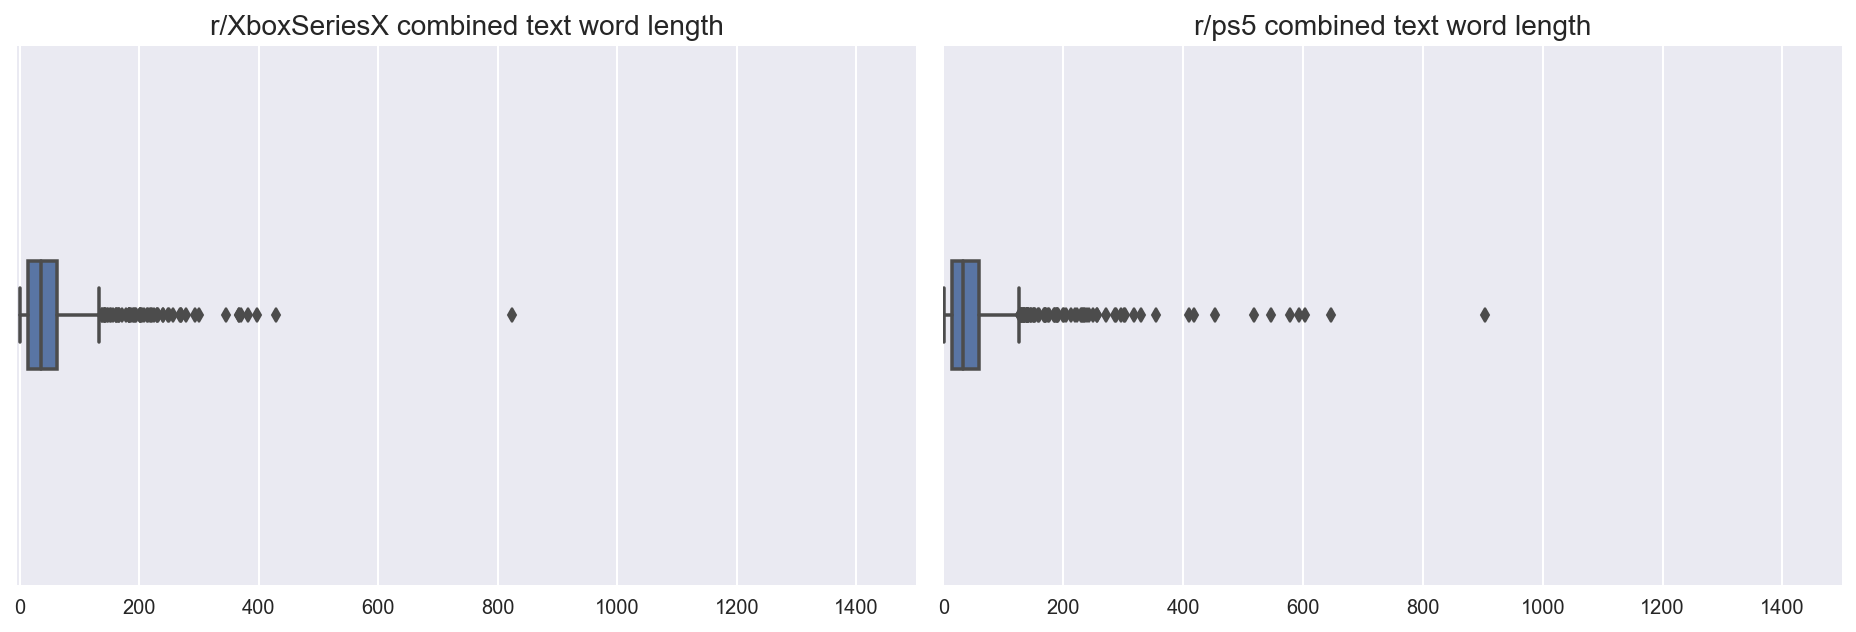

In [36]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4.5))

sns.boxplot(df_xboxseriesx['word_count_combined_text'], ax = ax[0], width = 0.2)
ax[0].set_xlabel('')
ax[0].set_xlim(-5,1500)
ax[0].set_title('r/XboxSeriesX combined text word length', fontsize=14)
sns.boxplot(df_ps5['word_count_combined_text'], ax = ax[1], width = 0.2)
ax[1].set_xlabel('')
ax[1].set_xlim(0,1500)
ax[1].set_title('r/ps5 combined text word length', fontsize=14)

print("PS5 has more posts with longer text content than XboxSeriesX, also meaning more outliers")
plt.tight_layout()

Shape of distribution for both subreddits is very similar


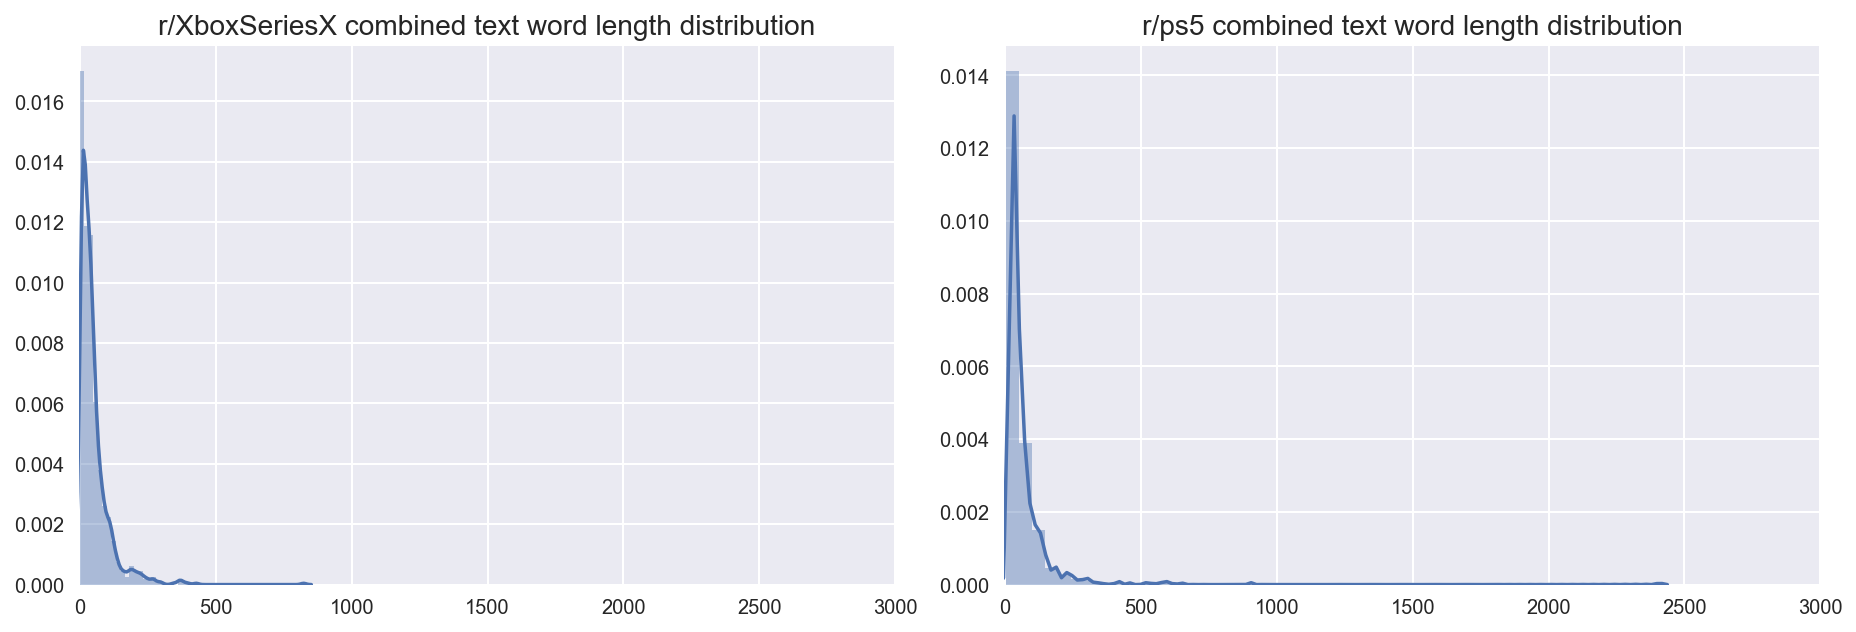

In [37]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4.5))

sns.distplot(df_xboxseriesx['word_count_combined_text'], ax = ax[0])
ax[0].set_xlabel('')
ax[0].set_xlim(-5,3000)
ax[0].set_title('r/XboxSeriesX combined text word length distribution', fontsize=14)
sns.distplot(df_ps5['word_count_combined_text'], ax = ax[1])
ax[1].set_xlabel('')
ax[1].set_xlim(-5,3000)
ax[1].set_title('r/ps5 combined text word length distribution', fontsize=14)


print("Shape of distribution for both subreddits is very similar")
plt.tight_layout()

### Deep Dive into Number of Comments

PS5 many more comments than XboxSeriesX.


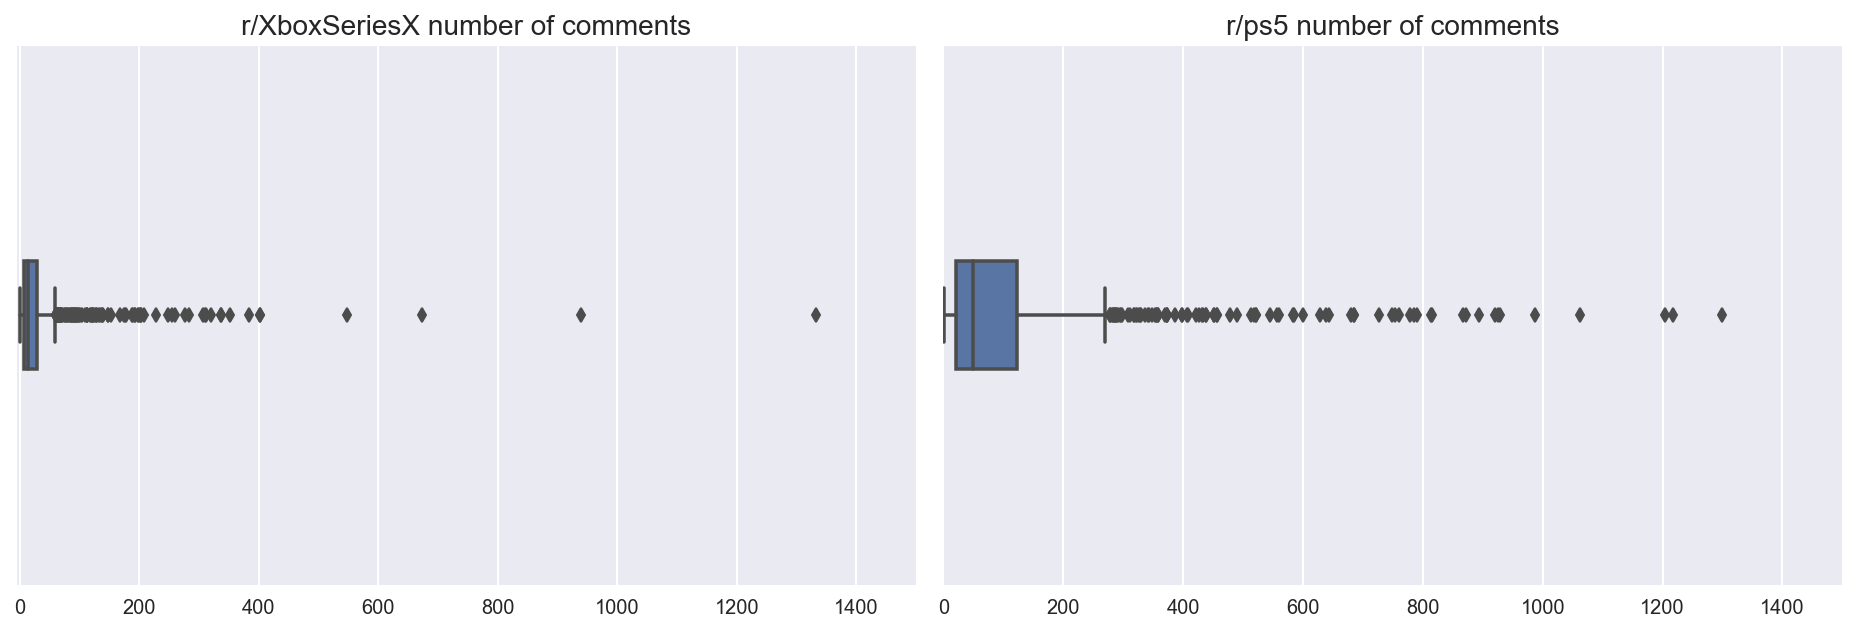

In [38]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4.5))

sns.boxplot(df_xboxseriesx['num_comments'], ax = ax[0], width = 0.2)
ax[0].set_xlabel('')
ax[0].set_xlim(-5,1500)
ax[0].set_title('r/XboxSeriesX number of comments', fontsize=14)
sns.boxplot(df_ps5['num_comments'], ax = ax[1], width = 0.2)
ax[1].set_xlabel('')
ax[1].set_xlim(0,1500)
ax[1].set_title('r/ps5 number of comments', fontsize=14)

print("PS5 many more comments than XboxSeriesX.")
plt.tight_layout()

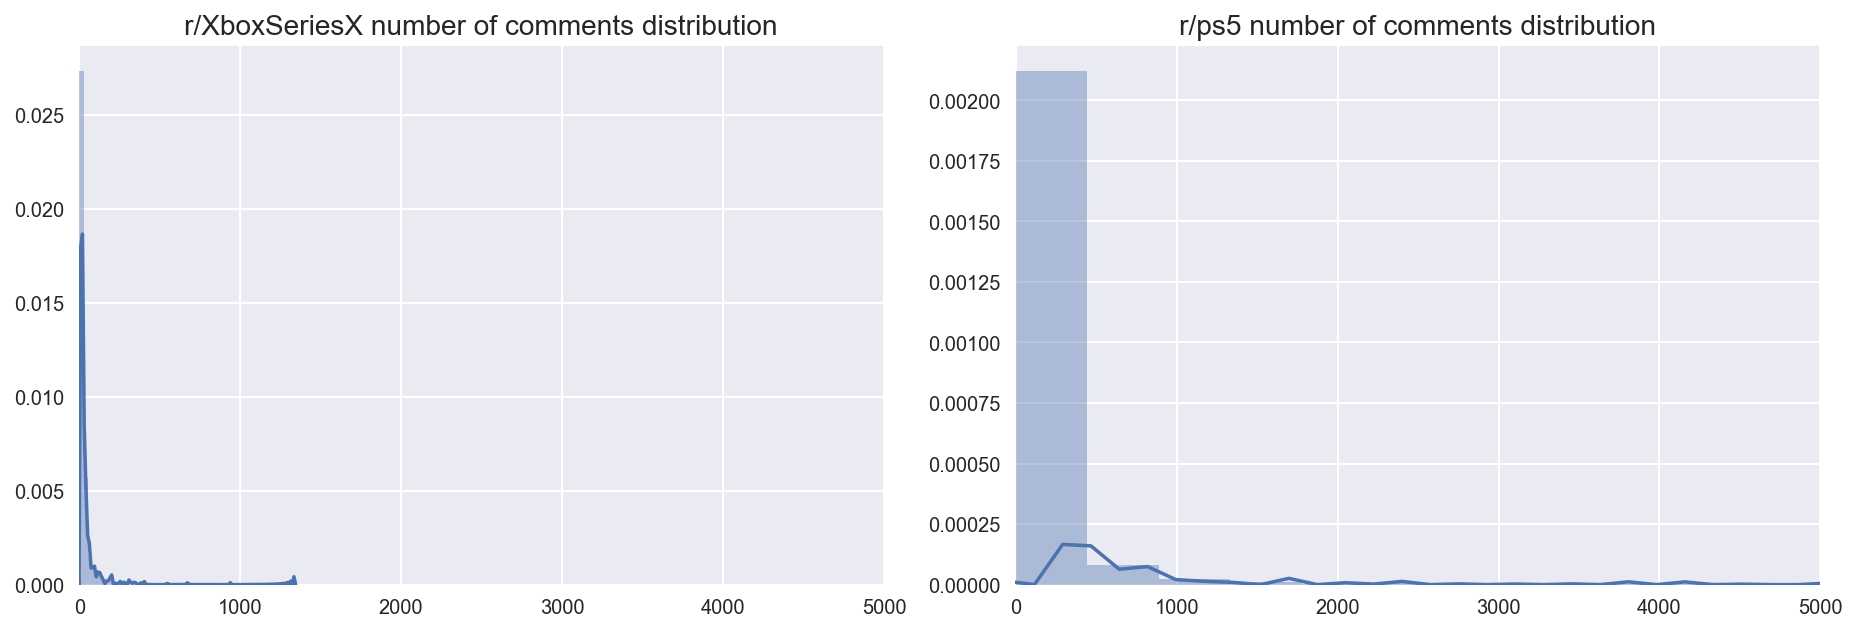

In [39]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 4.5))

sns.distplot(df_xboxseriesx['num_comments'], ax = ax[0])
ax[0].set_xlabel('')
ax[0].set_xlim(-5,5000)
ax[0].set_title('r/XboxSeriesX number of comments distribution', fontsize=14)
sns.distplot(df_ps5['num_comments'], ax = ax[1])
ax[1].set_xlabel('')
ax[1].set_xlim(-5,5000)
ax[1].set_title('r/ps5 number of comments distribution', fontsize=14)

plt.tight_layout()

Interestingly, the shape of distribution is different as there are more comments in PS5 subreddit. It seems that PS5 has more hype, depsite having lesser number of post.

In [40]:
df_xboxseriesx.describe().T

count        mean         std   min    25%    50%  \
score                     976.0  105.720287  655.194955  0.00   1.00   3.00   
upvote_ratio              976.0    0.691168    0.215446  0.07   0.55   0.72   
num_comments              976.0   32.298156   75.386690  0.00   7.00  14.00   
word_count_combined_text  976.0   51.100410   61.368029  0.00  14.00  34.50   

                            75%      max  
score                     24.00  16579.0  
upvote_ratio               0.86      1.0  
num_comments              28.00   1332.0  
word_count_combined_text  62.25    823.0

In [41]:
df_ps5.describe().T

count        mean          std   min    25%    50%  \
score                     930.0  383.684946  1771.738726  0.00   0.00  16.00   
upvote_ratio              930.0    0.612333     0.252430  0.08   0.39   0.65   
num_comments              930.0  183.875269   958.777995  1.00  22.00  49.00   
word_count_combined_text  930.0   56.613978   107.999245  2.00  15.00  33.00   

                             75%      max  
score                     136.75  36541.0  
upvote_ratio                0.84      1.0  
num_comments              123.75  22198.0  
word_count_combined_text   60.00   2410.0

**Summary statistics of score, upvote ratio, number of comments, word count of post**
- The max of scores for PS5 is 36541 and XboxSeriesX is 16579. Median for PS5 is 16, XboxSeriesX is 3. More upvoting for PS5 and it means more interesting posts in this subreddit.
- For upvote ratio, PS5 is lower at median 0.65 and XboxSeriesX is at 0.72. Meaning XboxSeriesX has more upvotes
- For length of post text, max for PS5 is 2410, XboxSeriesX is 823. Median for PS5 is 33 and XboxSeriesX is 34, which is very similar. Mean is also very similar at 56 for PS5 and 51 for XboxSeriesX. In a nutshell, there are a few posts in PS5 that has very long text.

Gernerally, PS5 seems to be a more interesting product than XboxSeriesX as it has more comments, higher scores. More discussions in PS5 and some posts can be very long.

For now, I dont think I can use anything of the above findings for my modeling. Likely I will separate the above columns into a dataframe to explore for Sentiment Analysis at preprocessing step.

Let us take a look at content of post!
### Deep Dive into Content of Post
- This section includes stop_words(aka outlier) removals. Stop words needs to be removed to peep into genuine content.
- Will explore overlapping words in both reddits
- Most frquent words in each subreddit

In [42]:
# function to examine top 20 words in combined_text

def top_20_words(subreddit):
    cvec = CountVectorizer() # purposefully not to use stop_words here as it is already removed
    cvec.fit(subreddit['combined_text'])

    subreddit_cv = pd.DataFrame(cvec.transform(subreddit['combined_text']).todense(),columns=cvec.get_feature_names())

    subreddit_combined_text = subreddit_cv.sum(axis=0)
    subreddit_combined_text = subreddit_combined_text.sort_values(ascending = False).head(20)
    subreddit_combined_text = pd.DataFrame(subreddit_combined_text,columns = ['count'])
    
    return subreddit_combined_text

In [43]:
top_20_words(df_xboxseriesx).T.columns
# Need to remove stop words to peep into genuine text content

Index(['the', 'and', 'xbox', 'for', 'series', 'that', 'have', 'will', 'one',
       'games', 'with', 'this', 'you', 'but', 'game', 'just', 'they', 'was',
       'get', 'can'],
      dtype='object')

In [44]:
top_20_words(df_ps5).T.columns
# Need to remove stop words to peep into genuine text content

Index(['the', 'and', 'for', 'ps5', 'that', 'you', 'games', 'this', 'will',
       'with', 'but', 'game', 'have', 'are', 'ps4', 'they', 'what', 'not',
       'like', 'just'],
      dtype='object')

Raw top 20 words for both subreddits contain many stop_words

#### Stop Words removal

In [45]:
# import stop_words = english
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\Hong
[nltk_data]     Yee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
print(stop_words)

{'themselves', 'do', 'below', 'll', "it's", 'am', "should've", 'his', 'any', 'your', 'off', 'if', "won't", 'being', 'been', 'such', 'through', 'i', 'very', 'doesn', 'once', 'had', 'more', 'herself', 'who', 'until', 'here', 'and', "doesn't", 'with', "you're", 'same', 'me', 'her', 'then', 're', 'its', 'how', 'our', "that'll", 'there', 'after', 'don', 'o', 'haven', 's', "shan't", 'd', "you've", 'above', 'shan', 'couldn', 'on', 'y', 'at', 'is', 'the', 'has', 'down', "hadn't", "wouldn't", 'up', 'ourselves', "you'll", 'wasn', "aren't", 'hasn', 'can', 'you', 'so', 'that', 'yourselves', "hasn't", "wasn't", 'those', 'yours', "isn't", 'too', 'he', 'which', "she's", 'when', 'having', 'ours', 'during', 'to', 'why', 'for', "you'd", 'further', "don't", 'some', "shouldn't", 'won', 'needn', 'they', 'hers', 'few', 'itself', 'she', 'were', 'again', 'most', 'does', 'each', 've', 'whom', 'from', 'where', 'while', 'wouldn', 'we', 'other', 'ma', 'doing', 'will', 'under', 'him', 'these', 'an', 'or', 'was', '

In [47]:
# apply stop_word = english removal to both subreddits
df_ps5['combined_text'] = df_ps5['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_xboxseriesx['combined_text'] = df_xboxseriesx['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

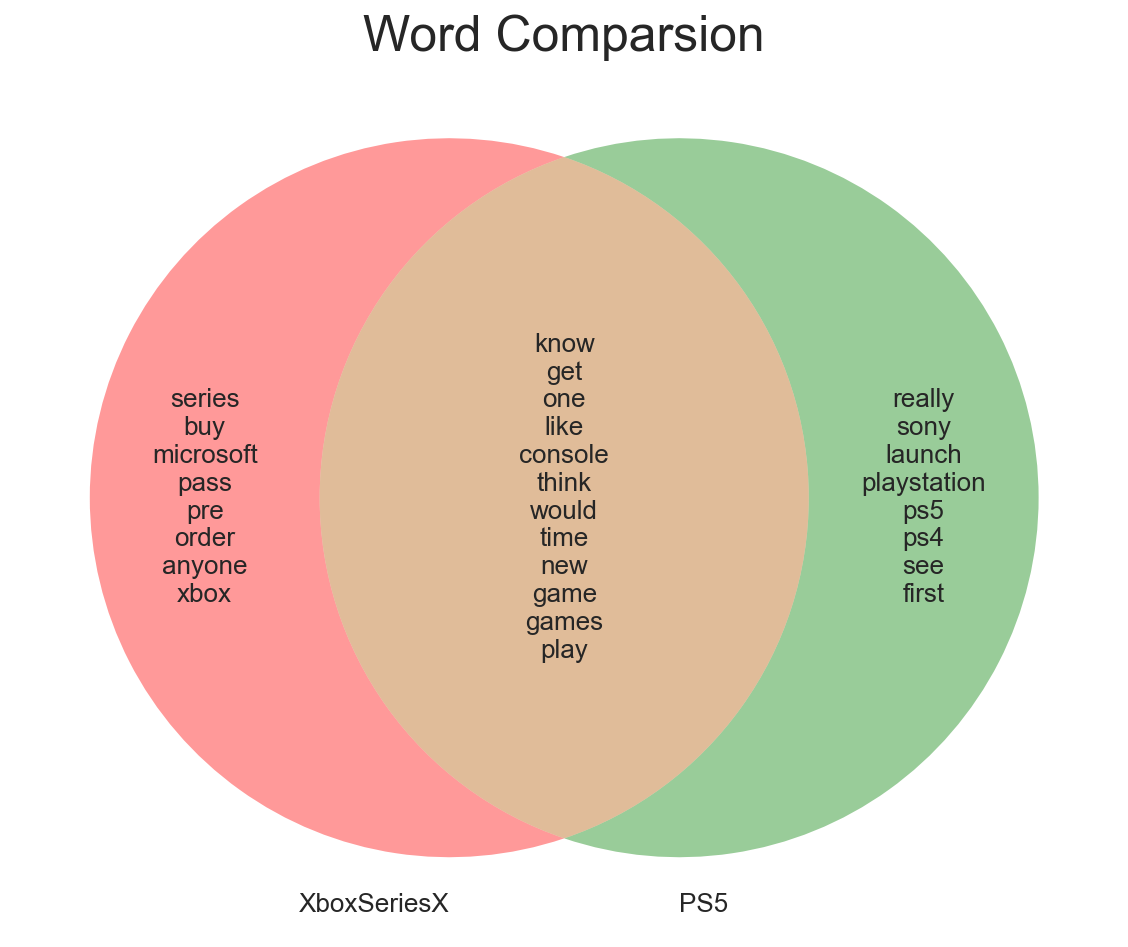

In [48]:
# venn diagram after stop words = "english" is applied
plt.figure(figsize=(15,8))

# Convert top words to set for drawing venn diagram
top_words_set_xbox = set(top_20_words(df_xboxseriesx).index)
top_words_set_ps5 = set(top_20_words(df_ps5).index)

# title
plt.title('Word Comparsion',fontsize=25)

# plot venn diagram
v = venn2.venn2([top_words_set_xbox, top_words_set_ps5], ('XboxSeriesX', 'PS5'))

# set font size
for text in v.set_labels:
    text.set_fontsize(13)
for text in v.subset_labels:
    text.set_fontsize(13)

# labeling of words
v.get_label_by_id('100').set_text('\n'.join(top_words_set_xbox-top_words_set_ps5))
v.get_label_by_id('110').set_text('\n'.join(top_words_set_xbox&top_words_set_ps5))
v.get_label_by_id('010').set_text('\n'.join(top_words_set_ps5-top_words_set_xbox))

After removing of 'english' stopwords, let us take alook of th top 20 words in each subreddit using venn diagram.

Many overlapping words like 'game', 'games'. These words are of the same root and can be removed by lemmatization/stemming. However, I would postpone this process to preprocessing because once lemmatization/stemming is applied, the words will be badly chopped for machine learning and will be hard to explore and read by humans. Eg 'pass' in r/XboxSeriesX will be chopped into 'pas' by lemmatization and stemming is even more brutal. Lots of 'wa', 'ha', 'do' will also appear. Which I got confused and thought that previous cleaning step was not performed properly. 

Since lemmatization/stemming will be explored at preprocessing step, words like 'game', 'games' will be removed by customized stop words. 'game', 'games' appeared in both subreddits and hence, i can include it into my stop words. Common words will not help in identifying a post during modeling because both subreddits contain these words. 

Additional stopwords will be 'games','game','play','like','new','know','get','think','one'

In [49]:
# Common words identified from the list above after first round of stop_words = 'english' removal
additional_stopwords = {'games','game','play','like','new','know','get','think','one'}
stop_words = stop_words.union(additional_stopwords)

In [50]:
# apply additional stop_words to both subreddits
df_ps5['combined_text'] = df_ps5['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df_xboxseriesx['combined_text'] = df_xboxseriesx['combined_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

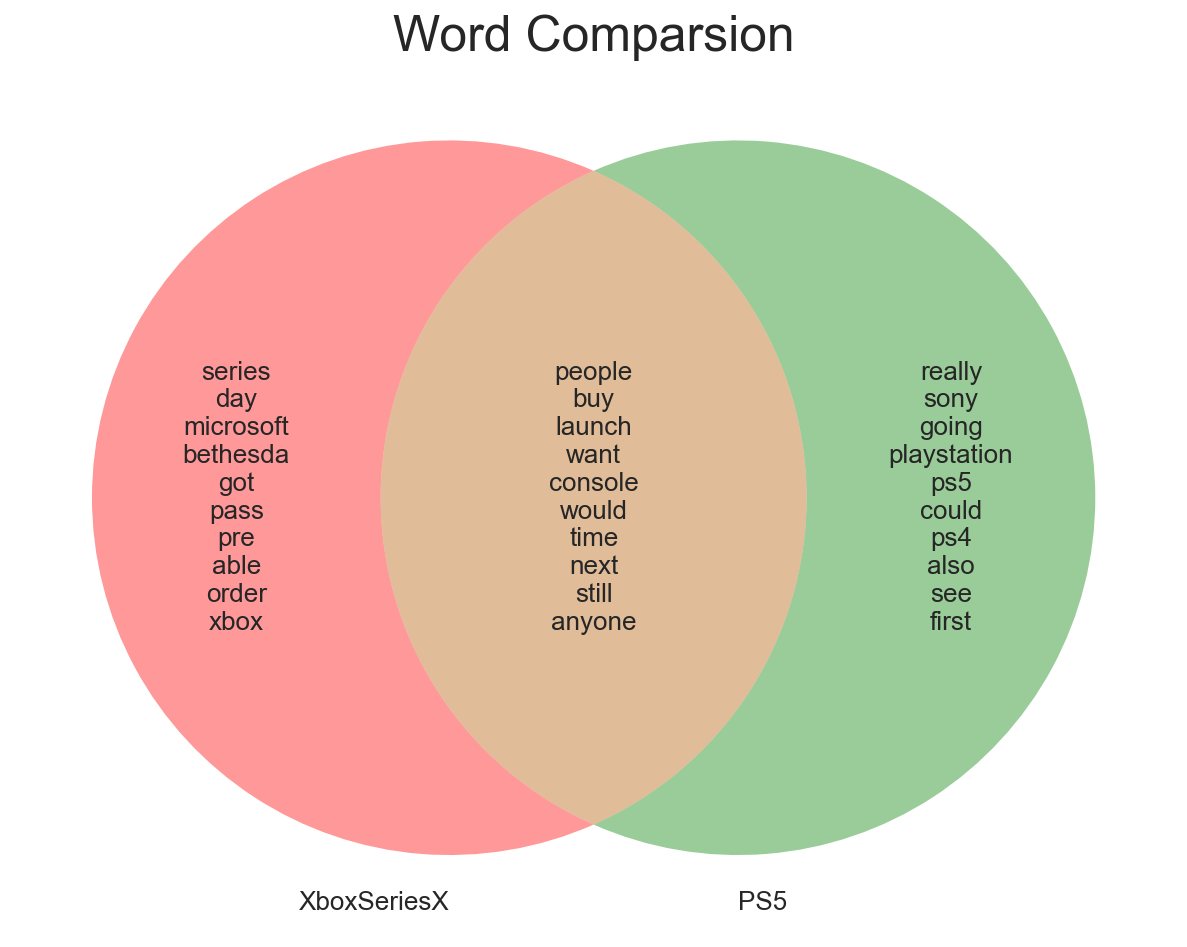

In [51]:
plt.figure(figsize=(15,8))

# Convert top words to set for drawing venn diagram
top_words_set_xbox = set(top_20_words(df_xboxseriesx).index)
top_words_set_ps5 = set(top_20_words(df_ps5).index)

# title
plt.title('Word Comparsion',fontsize=25)

# plot venn diagram
v = venn2.venn2([top_words_set_xbox, top_words_set_ps5], ('XboxSeriesX', 'PS5'))

# set font size
for text in v.set_labels:
    text.set_fontsize(13)
for text in v.subset_labels:
    text.set_fontsize(13)

# labeling of words
v.get_label_by_id('100').set_text('\n'.join(top_words_set_xbox-top_words_set_ps5))
v.get_label_by_id('110').set_text('\n'.join(top_words_set_xbox&top_words_set_ps5))
v.get_label_by_id('010').set_text('\n'.join(top_words_set_ps5-top_words_set_xbox))

The top_20 words improved for both subreddits after 2 rounds of stop_words removal. Common words were greatly reduced. Will stop with 2 rounds as over removing of stop_words will leads to losing training set that could be useful

**Output cleaned data into csv files**

In [52]:
# Output: saving xboxseriesx and ps5 after_cleaned dataframe posts to csv
df_ps5.to_csv('../data/ps5_posts_after_cleaned.csv', index = False)
df_xboxseriesx.to_csv('../data/df_xboxseriesx_posts_after_cleaned.csv', index = False)

After removing the stop words, we can concentrate on exploring the content text eg Top words frequency for both subreddits and compare them, make word cloud for better visualizaion

In [53]:
# Top words from PS5 title using Countvectorization

cvec = CountVectorizer(stop_words='english')
cvec.fit(df_ps5['combined_text'])

len_features = len(cvec.get_feature_names())
print("Total number of feature length for r/PS5 title is:", len_features)

df_ps5_cv = pd.DataFrame(cvec.transform(df_ps5['combined_text']).todense(),columns=cvec.get_feature_names())

top_ps5_40 = df_ps5_cv.sum(axis=0)
top_ps5_40 = top_ps5_40.sort_values(ascending = False).head(40)
top_ps5_40

Total number of feature length for r/PS5 title is: 5520


ps5            888
ps4            392
sony           320
playstation    177
launch         173
really         157
time           148
console        145
buy            124
people         124
going          122
want           121
make           109
gen            106
digital        103
getting        103
souls           99
good            99
able            98
version         94
plus            86
got             83
better          82
man             78
need            77
use             75
day             74
lot             72
work            72
controller      70
edit            70
available       70
edition         68
look            68
consoles        67
spider          66
ps3             65
hope            64
way             64
titles          63
dtype: int64

In [54]:
# Top words from XboxSeriesX title using Countvectorization
cvec = CountVectorizer(stop_words='english')
cvec.fit(df_xboxseriesx['combined_text'])

len_features = len(cvec.get_feature_names())
print("Total number of feature length for r/XboxSeriesX title is:", len_features)

df_xboxseriesx_cv = pd.DataFrame(cvec.transform(df_xboxseriesx['combined_text']).todense(),columns=cvec.get_feature_names())

top_xboxseriesx_40 = df_xboxseriesx_cv.sum(axis=0)
top_xboxseriesx_40 = top_xboxseriesx_40.sort_values(ascending = False).head(40)
top_xboxseriesx_40

Total number of feature length for r/XboxSeriesX title is: 4668


xbox         1023
series        742
microsoft     239
pre           236
console       204
order         204
buy           184
pass          171
time          148
got           132
able          130
day           123
want          121
bethesda      118
people        118
launch        113
work          111
consoles      107
gen           107
account       104
getting       101
going         100
gamepass       98
years          93
use            93
access         91
really         91
xsx            91
make           89
store          88
preorder       88
ps5            84
best           83
gold           81
good           75
question       75
gaming         74
amazon         72
release        72
credit         71
dtype: int64

The 2 subreddits have a difference in word count, with PS5 having 852 more words after stop_words removal. This is expected. We already know PS5 will have higher word count from our first part of EDA analysis on length of content analysis.

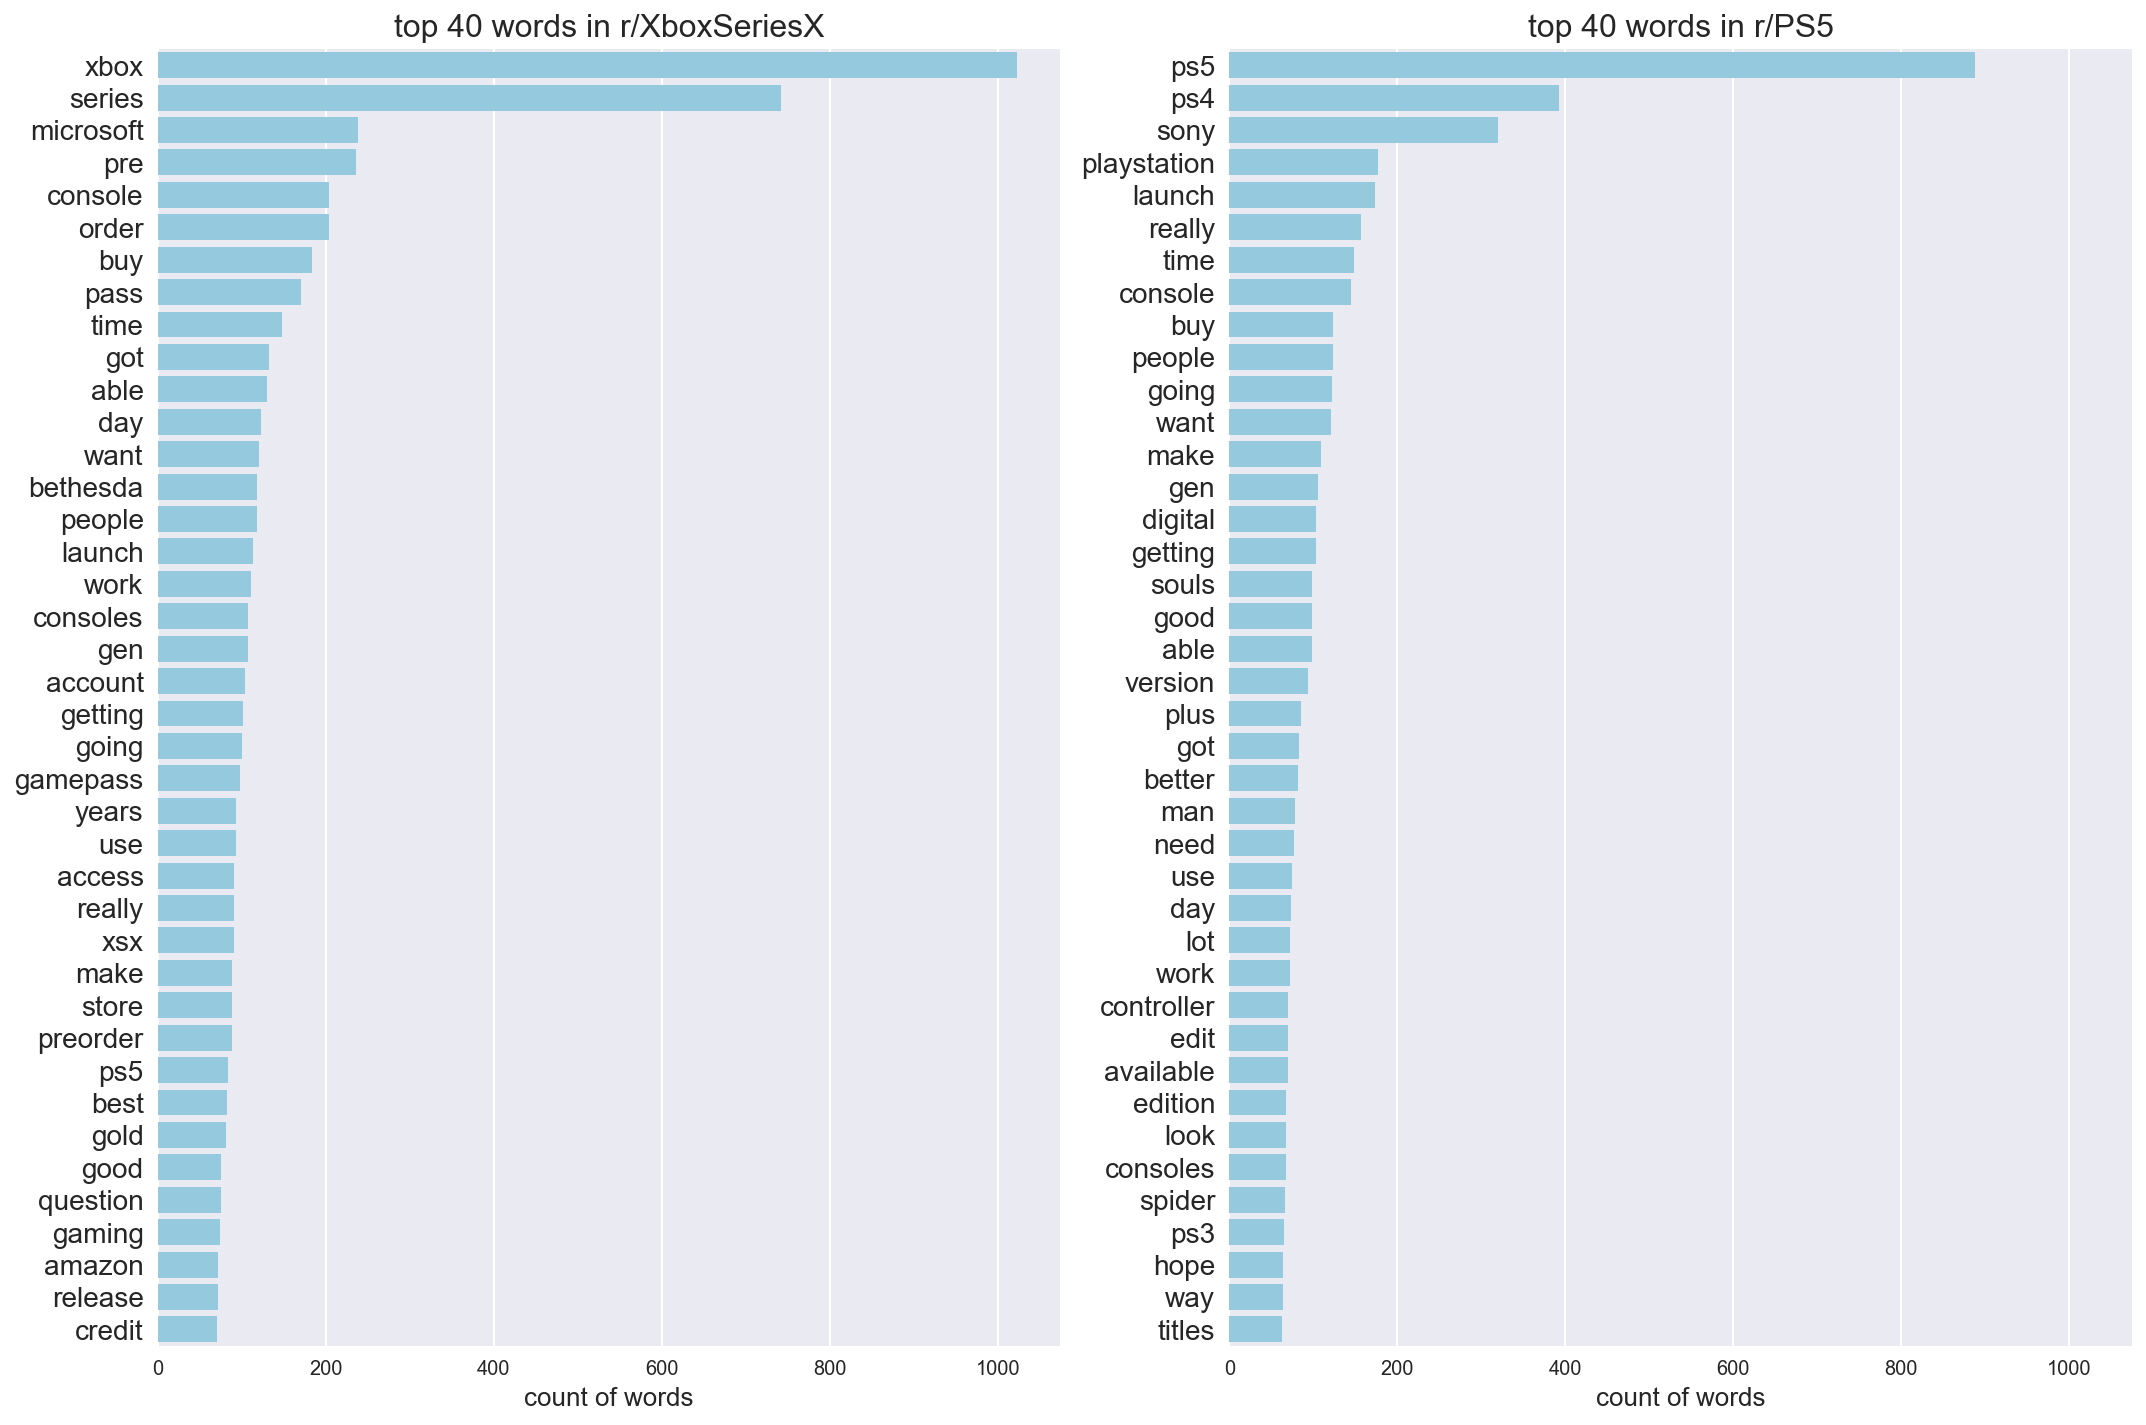

In [55]:
# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=top_xboxseriesx_40.index.values, x = top_xboxseriesx_40,color='skyblue',ax=ax[0])
ax[0].set_title('top 40 words in r/XboxSeriesX',fontsize=16)
ax[0].set_xlabel('count of words', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=top_ps5_40.index.values, x = top_ps5_40,color='skyblue',ax=ax[1])
ax[1].set_title('top 40 words in r/PS5',fontsize=16)
ax[1].set_xlabel('count of words', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Summary Statistics

There are still overlapping words in both subreddit eg 'console' because you cannot possibly remove all of them. 

For r/XboxSeriesX, word 'xbox' appeared 1023 times and 'series' appear 742 times.\
'microsoft' appeared 239 times, which is much lower than 'xbox' and 'series'.\
How are these 3 words related? Xbox is a video gaming brand created and owned by Microsoft. Series X is the 4th generation (latest) of this video game. 'pre' appeared 236 times because many people are talking about pre-ordering for Xbox Series X, that is going to launch at participating retailers worldwide on November 10, 2020 at \$499.99.

For r/PS5 on the other hand, top words are 'ps5', appeared 888 times, 'ps4' appeared 392 times. PS4 is the previous version of PS5, luanched in November 2013. PS5 will be luanched in November 12th this year by Sony at \$499.99 and is already generating alot of discussion. Word 'sony' (playstation manufacturer) appeared 320 times. 'playstation', full name for 'ps', appeared 177 times. Words like 'pre' doesnt appear in this top 40 list of high frequency words for r/PS5.

So both XboxSeriesX and PS5 will luanch almost same time this year at same price. PS5 has more comments and word length, seems to be generating more hype than XboxSeriesX, especially extract lesser posts from r/PS5 request. However, 'pre' appeared more times and its a top 40 words in r/XboxSeries. As expected, 'launch' is also an overlapping words between the 2 subreddit. 'launch' appeared 113 times in r/XboxSeriesX and 173 times in r/PS5

The top words are the product names (which is also the subreddit name) and manufacturer names. These common unique words can help us train data for our classification models, to classify an unknown subreddit post. The top frequent words in each subreddit is identified as per problem statement. It can also be use to differentiate each subreddit by counting the number of times it appeared, using Naive Bayes and Logistic Regression models.

### Word Cloud Comparison
Common words for XboxSeriesX subreddit are:
- xbox, series, microsoft, pre

Common words for XboxSeriesX subreddit are:
- ps5, ps4, sony, playstation

These words will strike a reader at first glance and would indicate to readers at first glance what Trading subreddit is mostly about, as these words appear frequently in the Trading subreddit

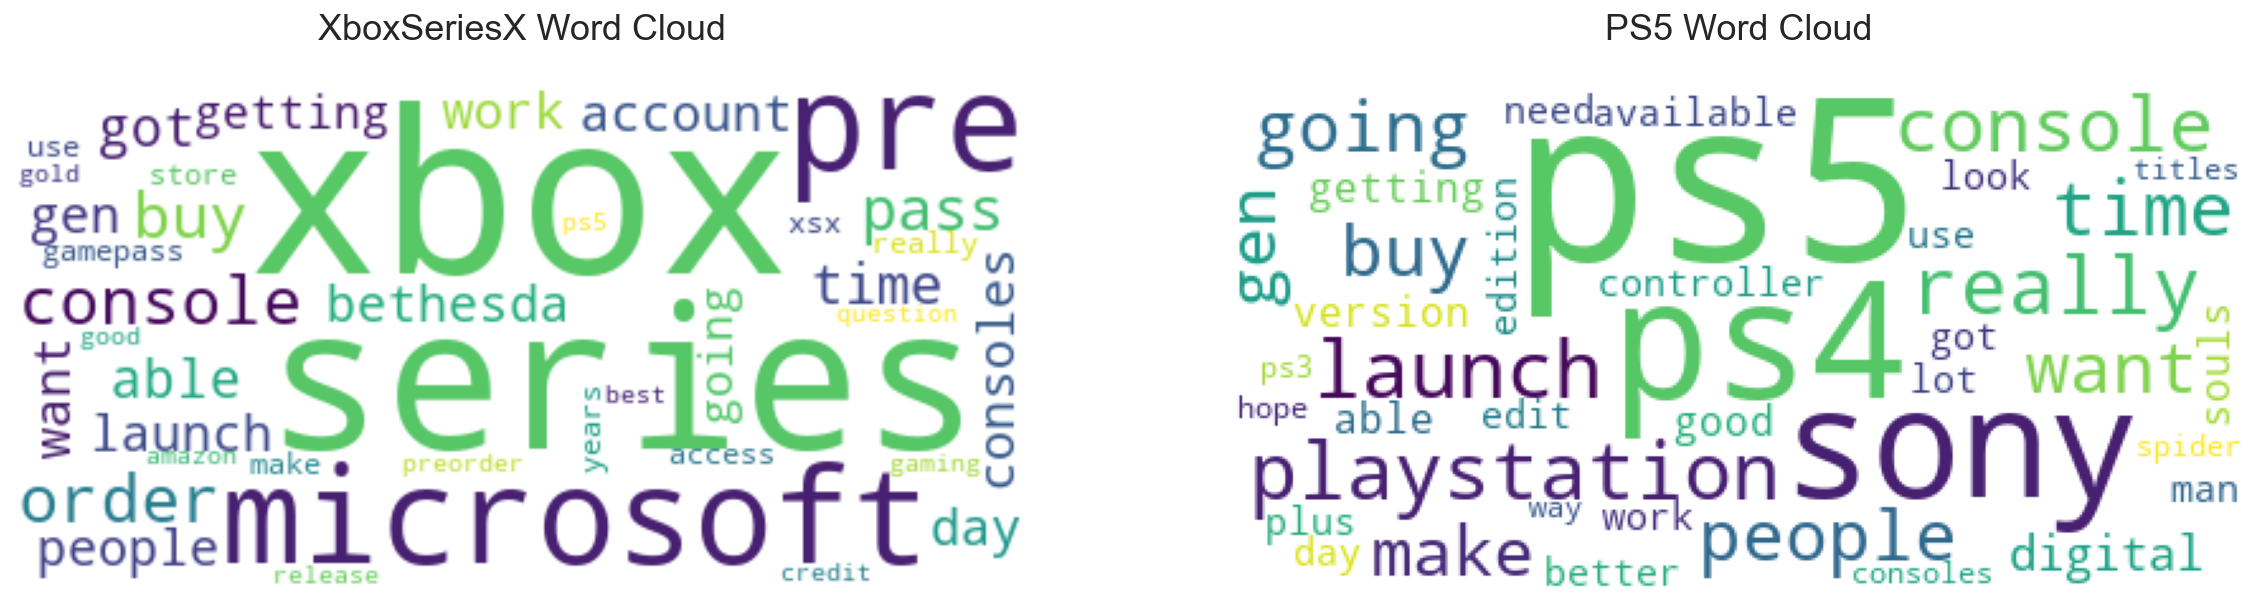

In [56]:
# wordcloud comparison for title

wc_ps5 = WordCloud(background_color="white", max_words=50, max_font_size=90, random_state=42)
wc_ps5.generate_from_frequencies(top_ps5_40)

wc_xboxseriesx = WordCloud(background_color="white", max_words=50, max_font_size=90, random_state=42)
wc_xboxseriesx.generate_from_frequencies(top_xboxseriesx_40)
              
# create coloring from image
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 20))

ax[0].imshow(wc_xboxseriesx, interpolation='bilinear')
ax[0].axis("off")
ax[0].set_title('XboxSeriesX Word Cloud', pad = 24, fontsize=18)

ax[1].set_title('PS5 Word Cloud', pad = 24, fontsize=18)
ax[1].imshow(wc_ps5)
ax[1].axis("off");

# Preprocessing

1) Explore stemming/lemmatizing\
2) One-hot encoding to form a classifiation column\
3) Combine both subreddit into a single dataframe\
4) Select features to create a single dataframe for sentiment analysis\
5) reset index\
6) check to ensure no null values\
7) Create feature matrix and target

## Explore stemming/lemmatizing

Explore both Stemming and Lemmatization. But select only 1 of them.

Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

Difference?\
Stemming technique only looks at the form of the word whereas lemmatization technique looks at the meaning of the word. It means after applying lemmatization, we will always get a valid word.

#### Try Stemming

In [57]:
porter_stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [58]:
# Apply stemming
df_xboxseriesx['combi_stem'] = df_xboxseriesx['combined_text'].apply(stem_sentences)
df_ps5['combi_stem'] = df_ps5['combined_text'].apply(stem_sentences)

In [59]:
df_ps5['combi_stem'].head()

0                                                                                                                              stop stop peopl ask question yessss use ps4 ps5 period
1                                                             playstat design studio microsoft design studio control isotop control similar servic soni also great servic ps5 control
2                                                                                                                abl download ps4 ps5 bought lot ps4 would hate loos ill decid upgrad
3                                                   connect ps4 extend storag hard drive ps5 access hard drive use extend storag ps4 ton possibl use devic ps5 without download stuff
4    playstat plu collect question come plu collect full come subscript portion buy someon work tri tell certain basic demo buy told make sens dumb wanna confirm full come subscript
Name: combi_stem, dtype: object

In [60]:
df_xboxseriesx['combi_stem'].head()

0                                                                                                                                                                                                                                                                                                                                random fan decid make awesom xgp trailer credit vincenzo fayez channel
1                                                                                                                                                                                                                                                                           taco bell deal avail countri pretti sure taco bell saudi arabia idk prize thing avail appreci help ye check googl say anyth
2                                                                                                state mous keyboard support xbox consol buy seri regardless mous keyboard support wonder current state mainli shooter p

#### Try lemmatization

In [61]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Hong
[nltk_data]     Yee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
# funcion to lemmatize
def lemma(text):
    tokens = tokenizer.tokenize(str(text))
    lems = [lemmatizer.lemmatize(i) for i in tokens]
    
    return(" ".join(lems))

In [63]:
# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

df_xboxseriesx['combined_text'] = df_xboxseriesx['combined_text'].apply(lambda x: lemma(x))
df_ps5['combined_text'] = df_ps5['combined_text'].apply(lambda x: lemma(x))

In [64]:
df_xboxseriesx['combined_text'].head()

0                                                                                                                                                                                                                                                                                                                                                                              random fan decided make awesome xgp trailer credit vincenzo fayez channel
1                                                                                                                                                                                                                                                                                                         taco bell deal available country pretty sure taco bell saudi arabia idk prize thing available appreciated help yes checked google say anything
2                                                                                                                state

In [65]:
df_ps5['combined_text'].head()

0                                                                                                                                                           stop stop people asking question yes use ps4 ps5 period
1                                                                            playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller
2                                                                                                                                          able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade
3                                                                       connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff
4    playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy 

### Summary of exploring Stemming or Lemmatization. Which one?
The best way to decide whether to use stemming or lemmatization is to run both data through the modeling process and see which method produces better variance, classification accuracy and confusion matrix scoring. Due to time constraint, this option was not be able to be performed. Generally, lemmatization is recommended for projects where the meaning of the text language is important to the success of the project. For this project, consideration of the text language meaning is not needed. However, I would prefer to use lemmatization because it is not as brutal as stemming. Stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. The thing is more brutal doesnt mean necessary or better. I prefer to use lemmatizationn for now.

### One-hot encoding to create a binary column for classification

In [66]:
# Create a binary column for each subreddit. df_xboxseriesx = 1, df_ps5 = 2
# One hot encoding

df_ps5['is_xbox'] = 0
df_xboxseriesx['is_xbox'] = 1

In [67]:
# sanity check on datafram r/XboxSeriesX
df_xboxseriesx.head()

score  upvote_ratio  num_comments  \
0     13          0.88             7   
1      0          0.25             1   
2      2          1.00             4   
3      0          0.09             3   
4      1          1.00             2   

                                                                                                                                                                                                                                                                                                                                                                                                                                         combined_text  \
0                                                                                                                                                                                                                                                                                                                                                                            random fan decided make awesome xgp trailer credit vincenzo fayez channel   
1                                                                                                                                                                                                                                                                                                       taco bell deal available country pretty sure taco bell saudi arabia idk prize thing available appreciated help yes checked google say anything   
2                                                                                                              state mouse keyboard support xbox console buying series regardless mouse keyboard support wondering current state mainly shooter playing console controller feel drunk incredibly slow inaccurate understand support mouse keyboard single player true shooter really care multiplayer anymore would title doom mouse keyboard possible   
3                                                                                                                                                                                                                                                                                                                                                                                    anyone posted yet amazon release date halo infinite december 31st   
4  upgrade series price range two real option vizio tcl series inch vizio sold tcl 1440p interested since seems realistically afford panel however seems tcl blooming issue around text every video ive seen black crush insanely bad anyone experience tcl blooming black crush really bad youtube video exaggerating bad comparison vizio doesnt seem crush black video ive watched really want frame multiplayer black crush seems beyond noticable   

   word_count_combined_text  \
0                        12   
1                        31   
2                        75   
3                        18   
4                       105   

                                                                                                                                                                                                                                                                                                                                                                                           combi_stem  \
0                                                                                                                                                                                                                                                                                                                              random fan decid make awesom xgp trailer credit vincenzo fayez channel   
1                                                                                                                                       

In [68]:
# sanity check on datafram r/PS5
df_ps5.head()

score  upvote_ratio  num_comments  \
0      1          0.67             9   
1      3          1.00             1   
2      0          0.17             6   
3      0          0.33             8   
4      0          0.29             7   

                                                                                                                                                                                                    combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   word_count_combined_text  \
0                        23   
1                        29   
2                        19   
3                        41   
4                        67   

                                                                                                                                                                         combi_stem  \
0                                                                                                                            stop stop peopl ask question yessss use ps4 ps5 period   
1                                                           playstat design studio microsoft design studio control isotop control similar servic soni also great servic ps5 control   
2                                                                                                              abl download ps4 ps5 bought lot ps4 would hate loos ill decid upgrad   
3                                                 connect ps4 extend storag hard drive ps5 access hard drive use extend storag ps4 ton possibl use devic ps5 without download stuff   
4  playstat plu collect question come plu collect full come subscript portion buy someon work tri tell certain basic demo buy told make sens dumb wanna confirm full come subscript   

   is_xbox  
0        0  
1        0  
2        0  
3        0  
4        0

### Prepare a combined, single dataframe for modeling
- Create a combined dataframe of both subreddits for modeling. Name of dataframe is: ps5_xboxseriesx
- Create a dataframe for setiment analysis. Dataframe Name is: ps5_xboxseriesx_sentiment

In [69]:
# Concatenating both dataframes 
ps5_xboxseriesx = pd.concat([df_ps5, df_xboxseriesx])

In [70]:
# to prepare a dataframe for sentiment analysis later
ps5_xboxseriesx_sentiment = ps5_xboxseriesx[['combined_text', 'is_xbox', 'score', 'num_comments', 'upvote_ratio']]

In [71]:
# check! shape
ps5_xboxseriesx_sentiment.shape 

(1906, 5)

In [72]:
# Select combined_text (main text), is_xbox column (class name for model training and testing)

ps5_xboxseriesx = ps5_xboxseriesx[['combined_text', 'is_xbox']]

In [73]:
# Check! shape
ps5_xboxseriesx.shape

(1906, 2)

In [74]:
# reset index for modeling file
ps5_xboxseriesx.reset_index(drop=True).head()

combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   is_xbox  
0        0  
1        0  
2        0  
3        0  
4        0

In [75]:
# reset index for sentiment analysis file
ps5_xboxseriesx_sentiment.reset_index(drop=True).head()

combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   is_xbox  score  num_comments  upvote_ratio  
0        0      1             9          0.67  
1        0      3             1          1.00  
2        0      0             6          0.17  
3        0      0             8          0.33  
4        0      0             7          0.29

In [76]:
# Last check for isnull to ensure no missing data
ps5_xboxseriesx.isnull().sum()

combined_text    0
is_xbox          0
dtype: int64

In [77]:
# Output: combined processed dataframe posts to csv
ps5_xboxseriesx.to_csv('../data/combined_preprocessed.csv', index = False)

## Create Feature Matrix (X =combined_text) and Target (y subreddit class=is_xbox)
3 sets of data is need to be created.

1) training set to train all models (60% of the data available)\
2) test set to check for accuracy after each modeling (20% of the data available)\
3) test best model selected using an unseen data to confirm performance (20% of the data available)

In [78]:
# create X (feature matrix(for combined_text)) and y (target is xbox)

X = ps5_xboxseriesx['combined_text']
y = ps5_xboxseriesx['is_xbox']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1, stratify=y_train) # 0.25 x 0.8 = 0.2

In [79]:
print(X_train.shape) # X_train, y_train will be used to train my models (60%)
print(y_train.shape)

print(X_test.shape) # X_test, y_test will be used to test the models (20%)
print(y_test.shape)

print(X_val.shape) # X_val, y_val will be used as unseen data to test the final selected model (20%)
print(y_val.shape)

(1143,)
(1143,)
(382,)
(382,)
(381,)
(381,)


# Modeling

Create 2 by 2 models:

1) 2 classification models - Logistic Regression vs Naive Bayes

- Logistic Regression is a binary classfication model, it will be, not Xbox = PS5 post = 0 or Xbox post = 1
- Naive Bayes explained: There are 3 types of Naive Bayes model
    - Gaussian: It is used in classification and it assumes that features follow a normal distribution.
    - Multinomial: It is used for discrete counts.
    - The binomial model is useful if your feature vectors are binary (i.e. zeros and ones).
    - We will be using Multinomial because we are not only predicting whether word was there, but also how many times the word appeared. Meaning, we are counting each word to predict the class or label.

2) 2 types of feature selection - Countvectorization vs TfidfVectorizer\
TfidfVectorizer: Common words are penalized. Rare words have more influence as compared to countvectorizer.\
Countvectorization will take take non-duplicated words as its vocabulary a.k.a the feature

#### Steps taken:
1) Obtain a baseline score\
2) Modeling using pipeline Naive Bayes with TfidfVectorizer.\
3) Modeling using pipeline Naive Bayes with CountVectorizer\
4) Modeling using pipeline Logistic Regression Modeling with TfidfVectorizer\
5) Modeling using pipeline Logistic Regression Modeling with CountVectorizer

- Train each model on training dataset (X_train, y_train dataset).
- Test each model on test dataset (X_test, y_test dataset).
- Test best model using unseen dataset (X_val, y_val dataset).
- Analyze confusion matrix for all models and obtain accuracy, sensitivity, specificity, precision for comparison.

## Zero Rule Algorithm to obtain baseline
ZeroR is the simplest classification method which relies on the target and ignores all predictors. ZeroR classifier simply predicts the majority category (class). Although there is no predictability power in ZeroR, it is useful for determining a baseline performance as a benchmark for classification methods.

In [80]:
print("Accuracy of the baseline using Zero Rule Algorithm is") 
y_test.value_counts(normalize=True)

Accuracy of the baseline using Zero Rule Algorithm is


1    0.513089
0    0.486911
Name: is_xbox, dtype: float64

## Modeling by Pipeline Naive Bayes with TfidfVectorizer

In [81]:
pipe_nb_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

params_nb_tf = {
    'tf__max_features': [1000, 2000, 3000, 4000, 5000], 
    'tf__ngram_range':  [(1, 1), (1, 2), (1, 3)],
}

gs_nb_tf = GridSearchCV(pipe_nb_tf, 
                        param_grid=params_nb_tf,
                        cv=5,
                        n_jobs=2,
                        verbose=1)
    
gs_nb_tf.fit(X_train, y_train)

print(f'GridSearch Best Params:{gs_nb_tf.best_params_}')
print('Train Score:', gs_nb_tf.score(X_train, y_train))
print('Test Score:', gs_nb_tf.score(X_test, y_test))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    9.0s finished


GridSearch Best Params:{'tf__max_features': 5000, 'tf__ngram_range': (1, 3)}
Train Score: 0.9667541557305337
Test Score: 0.8612565445026178


In [82]:
# Confusion matrix parameters function 

def conf_matrix(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    # get confusion matrix data
    cm = confusion_matrix(y_test, y_hat)  
    # extract elements of confusion matrix
    tn, fp, fn, tp = cm.ravel()        
    
    # Convert Confusion Matrix to DataFrame
    df_cm = pd.DataFrame(cm, columns=['pred negative', 'pred positive'], index=['actual_negative', 'actual positive'])
    return df_cm
    
def conf_matrix_metrics(model, X_test, y_test):
    y_hat = model.predict(X_test) 
    cm = confusion_matrix(y_test, y_hat)  
    tn, fp, fn, tp = cm.ravel()           
    
    #calculate metrics 
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    sensitivity = tp / (tp + fn)
    specificity = tn/ (tn + fp)
    precision = tp /(tp + fp)
    
    return {'accuracy': np.round(accuracy,3),
            'sensitivity': np.round(sensitivity,3),
            'specificity': np.round(specificity,3),
            'precision': np.round(precision,3)}

In [83]:
print(conf_matrix(gs_nb_tf, X_test, y_test))
conf_matrix_metrics(gs_nb_tf, X_test, y_test)

                 pred negative  pred positive
actual_negative            150             36
actual positive             17            179


{'accuracy': 0.861,
 'sensitivity': 0.913,
 'specificity': 0.806,
 'precision': 0.833}

## Modeling by Pipeline Naive Bayes with CountVectorizer

In [84]:
pipe_nb_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params_nb_cvec = {
    'cvec__max_features': [100, 500, 1000, 2000, 3000, 4000, 5000], 
    'cvec__ngram_range':[(1, 1), (1, 2), (1, 3)],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
}

gs_nb_cvec = GridSearchCV(pipe_nb_cvec, 
                        param_grid=params_nb_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)
    
gs_nb_cvec.fit(X_train, y_train)

print(f'GridSearch Best Params:{gs_nb_cvec.best_params_}')
print('Train Score:', gs_nb_cvec.score(X_train, y_train))
print('Test Score:', gs_nb_cvec.score(X_test, y_test))

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    6.6s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   30.7s
[Parallel(n_jobs=2)]: Done 420 out of 420 | elapsed:   33.4s finished


GridSearch Best Params:{'cvec__max_df': 0.9, 'cvec__max_features': 3000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2)}
Train Score: 0.9361329833770778
Test Score: 0.8769633507853403


In [85]:
print(conf_matrix(gs_nb_cvec, X_test, y_test))
conf_matrix_metrics(gs_nb_cvec, X_test, y_test)

                 pred negative  pred positive
actual_negative            161             25
actual positive             22            174


{'accuracy': 0.877,
 'sensitivity': 0.888,
 'specificity': 0.866,
 'precision': 0.874}

## Modeling by Pipeline Logistic Regression Modeling with TfidfVectorizer

In [86]:
pipe_lr_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_tf = {
    'tf__max_features': [1000, 2000, 3000, 4000], 
    'tf__ngram_range':  [(1, 1), (1, 2), (1, 3)], 
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42] 
}
gs_lr_tf = GridSearchCV(pipe_lr_tf, 
                        param_grid=params_lr_tf,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_tf.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_lr_tf.best_params_}')
print('Train Score:', gs_lr_tf.score(X_train, y_train))
print('Test Score:', gs_lr_tf.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   16.7s
[Parallel(n_jobs=2)]: Done 360 out of 360 | elapsed:   30.0s finished


GridSearch Best Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__random_state': 42, 'tf__max_features': 4000, 'tf__ngram_range': (1, 2)}
Train Score: 0.9746281714785652
Test Score: 0.887434554973822


In [87]:
print(conf_matrix(gs_lr_tf, X_test, y_test))
conf_matrix_metrics(gs_lr_tf, X_test, y_test)

                 pred negative  pred positive
actual_negative            169             17
actual positive             26            170


{'accuracy': 0.887,
 'sensitivity': 0.867,
 'specificity': 0.909,
 'precision': 0.909}

## Modeling by Pipeline Logistic Regression Modeling with Countvectorizer

In [88]:
pipe_lr_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

params_lr_cvec = {
    'cvec__stop_words': [None, 'english'],
    'cvec__max_features': [100, 500, 1000, 2000, 3000, 4000, 5000], 
    'cvec__ngram_range':[(1, 1), (1, 2), (1, 3)],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'lr__penalty':      ['l2', 'l1'],
    'lr__C':            [.5, .01, 1],
    'lr__random_state': [42] 
}
gs_lr_cvec = GridSearchCV(pipe_lr_cvec, 
                        param_grid=params_lr_cvec,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lr_cvec.fit(X_train, y_train)

print(f'GridSearch Best Params: {gs_lr_cvec.best_params_}')
print('Train Score:', gs_lr_cvec.score(X_train, y_train))
print('Test Score:', gs_lr_cvec.score(X_test, y_test))

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 764 tasks      | elapsed:   55.8s
[Parallel(n_jobs=2)]: Done 1276 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 1976 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done 2876 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 3976 tasks      | elapsed:  5.1min


GridSearch Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'lr__C': 0.01, 'lr__penalty': 'l2', 'lr__random_state': 42}
Train Score: 0.9081364829396326
Test Score: 0.8900523560209425


[Parallel(n_jobs=2)]: Done 5040 out of 5040 | elapsed:  6.7min finished


In [89]:
print(conf_matrix(gs_lr_cvec, X_test, y_test))
conf_matrix_metrics(gs_lr_cvec, X_test, y_test)

                 pred negative  pred positive
actual_negative            175             11
actual positive             31            165


{'accuracy': 0.89,
 'sensitivity': 0.842,
 'specificity': 0.941,
 'precision': 0.938}

### Summary of models performance

All the models are underperforming on test data. The reason is because Grid Search gets the best performing model on train set, hence when applied on test set data, it will under perform.

All the models on training set achieved minimum 0.9 and test score achieved minimum 0.85.\
All the models showed at least 1.67x better accuracy score than the baseline.

For Naive Bayes + TF-IDF it achieved 0.960 and 0.850 on test data, the differential is 0.11\
For Naive Bayes + CVEC it achieved 0.936 and 0.876 on test data, the differential is 0.6\
For LR + TV-IDF it achieved 0.974 on train and 0.890 on test data, the differential is 0.08\
For LR + CVEC it achieved 0.907 on train and 0.887 on test data, the differential is 0.02

Hence the best model is Logistic Regression model with CounterVectorizer because the train and test score is closest to each other. We can predict with an accuracy of about 88.7% where a given post came from.

| Dataset 	| Naive Bayes + TF-IDF 	| Naive Bayes +   CVEC 	| Logistic +   TV-IDF 	| Logistic + CVEC 	|
|:-:	|:-:	|:-:	|:-:	|:-:	|
| Train 	| 0.960629921 	| 0.936132983 	| 0.974628171 	| 0.907261592 	|
| Test 	| 0.85078534 	| 0.876963351 	| 0.890052356 	| 0.887434555 	|
| Confusion Matrix 	| True Negative: 149<br>     False Negative: 20<br>     False Positive: 37<br>     True Positive: 176 	| True Negative: 161<br>     False Negative: 22<br>     False Positive: 25<br>     True Positive: 174 	| True Negative: 169<br>     False Negative: 25<br>     False Positive: 17<br>     True Positive: 171 	| True Negative: 174<br>     False Negative: 31<br>     False Positive: 12<br>     True Positive: 165 	|
| Confusion   Matrix Parameters  	| accuracy: 0.851<br>      sensitivity: 0.898<br>      specificity: 0.801<br>      precision: 0.826 	| accuracy: 0.877<br>      sensitivity: 0.888<br>      specificity: 0.866<br>      precision: 0.874 	| accuracy: 0.89<br>      sensitivity: 0.872<br>      specificity: 0.909<br>      precision: 0.91 	| accuracy: 0.887<br>      sensitivity: 0.842<br>      specificity: 0.935<br>      precision: 0.932 	|

Lets also look at this best model's performance on unseen data!\
Before that lets model fit Logistic Regression + CVEC.

## Model fit with Logistic Regression + CVEC

In [90]:
# load the parameters
gs_lr_cvec.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 1000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None,
 'lr__C': 0.01,
 'lr__penalty': 'l2',
 'lr__random_state': 42}

In [91]:
# Use pipeline to generate the model
final_lr_cvec = Pipeline([
    
    ('cvec', CountVectorizer(max_df= 0.9,
         max_features= 1000,
         min_df= 2,
         ngram_range= (1, 1),
         stop_words= None)),
     
     ('lr', LogisticRegression(C= 0.01, penalty= 'l2', random_state= 42))

     ])

In [92]:
# fit using training set
final_lr_cvec.fit(X_train,y_train)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=1000, min_df=2)),
                ('lr', LogisticRegression(C=0.01, random_state=42))])

In [93]:
# score training data
final_lr_cvec.score(X_train,y_train)

0.9081364829396326

In [94]:
# score test data
final_lr_cvec.score(X_test,y_test)

0.8900523560209425

In [95]:
# score unseen data set
final_lr_cvec.score(X_val,y_val)

0.884514435695538

In [96]:
# Generate our predictions using unseen data
pred = final_lr_cvec.predict(X_val)

In [97]:
# Making a dataframe with test data, which contains final_posts, actual class value, 
# predicted class value, and predict probability

results = pd.DataFrame(X_val, columns=['combined_text']) # making a dataframe on one column known
# as combined_text_X_unseen
results['actual'] = y_val# add 'actual' column
results['predictions'] = pred
results['predict_proba'] = [i[1] for i in final_lr_cvec.predict_proba(X_val)]
results.shape

(381, 4)

In [98]:
results

combined_text  \
587                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    would hurt ps5 kept slanted would harm device let stay slanted cube jpg quite literally anywhere else place device yet   
899                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

# Modeling Evaluation
Generating confusion matrix using unseen data

In [99]:
# Generate a confusion matrix.
cm = confusion_matrix(y_val, pred)
# convert into dataframe for better view
df_cm = pd.DataFrame(cm, columns=['pred negative', 'pred positive'], index=['actual_negative', 'actual positive'])
print("---------- This is the confusion matrix --------------")
print(df_cm)
print("------------------------------------------------------")
print('')

# assign terms for each confusion matrix parameter
tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()

# print out the scores
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print('')

# look at the scores of the parameters
accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
print('')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

---------- This is the confusion matrix --------------
                 pred negative  pred positive
actual_negative            179              7
actual positive             37            158
------------------------------------------------------

True Negatives: 179
False Positives: 7
False Negatives: 37
True Positives: 158


Accuracy: 0.885
Sensitivity: 0.81
Specificity: 0.962
Precision: 0.958


In [100]:
#Retrieve roc_auc_score
roc_auc_score(results['actual'], results['predict_proba'] )

0.9698511166253101

In [101]:
# F1_score = 2*(Recall * Precision) / (Recall + Precision)

F1_score = (2*(0.81*0.958))/(0.81+0.958)
F1_score

0.8778054298642534

### Best model Logistic Regression + CVEC achieved 88.5% score on unseen data

**Performance matrix**:

|  	| Train 	| Test 	| Unseen 	|  	|
|-	|:-:	|:-:	|:-:	|-	|
| score 	| 0.907261592 	| 0.887434555 	| 0.884514436 	|  	|
| confusion   matrix 	| not generated 	| True Negative: 174<br>     False Negative: 31<br>     False Positive: 12<br>     True Positive: 165 	| True Negatives: 179<br>     False Negatives: 37<br>     False Positives: 7<br>     True Positives: 158 	|  	|
| confusion   matrix parameters 	| not generated 	| accuracy: 0.887<br>      sensitivity: 0.842<br>      specificity: 0.935<br>      precision: 0.932 	| accuracy: 0.885<br>     sensitivity: 0.81<br>     specificity: 0.962<br>     precision: 0.958 	|  	|


Negative = PS5 = 0 = not Xbox\
Positive = Xbox = 1 = not PS5\
True positive = 158 posts, correctly predicted Xbox post\
True negative = 179 posts, correctly predicted as PS5 post\
False positive = 7 posts, PS5 posts predicted as Xbox\
False negative = 37 posts, Xbox posts predicted as PS5\

Type I error = False Positive = 7 posts\
Type II error = False Negative = 37 posts\
In this case, there is no 'worse-off' for being Type I or Type II error. This is because misclassification a post into either subreddit is equally bad. Hence unable to explain which error is worse.

**Intepretation:**
- Accuracy of unseen data is 88.5% meaning the model predicted 88.5% of the unseen data correctly to the correct subreddit.
- Misclassification rate = 11.5% means 11.5% of the posts did not get to classify correctly.
- Sensitivity (recall) is 81%, meaning if a post that belongs to Xbox subreddit, 81% probability that it will be identified as a post from Xbox subreddit.
- Specificity 96.2%, meaning that if a post is belongs to PS5, 96.2% probability that it will be predicted as PS5 subreddit.
- Precision is 95.8%, meaning 95.8% probability of those posts predicted as Xbox, actually really belongs to Xbox subreddit.
- F1 Score is 87.7% which is the weighted average of Precision and sensitivity. It takes both false positives and false negatives into account. This is usually more suitable to be used for unbalanced class distribution.
- ROC AUC value is 0.969. This is an excellent discrimination score. Meaning the test has great ability to correctly classify posts to the correct subreddit.

### Top predictive words
The model gives each word a score to predict the positive class. The higher the weightage, the more likely the words can predict towards XboxSeriesX subreddit.

The top predictive words identified for XboxSeriesX subreddit is ('xbox', 'series', 'microsoft', 'order', 'pre')\
The top predictive words identified for PS5 subreddit is ('ps5', 'sony', 'ps4', 'playstation', 'soul')\
**Please see below for the full list:**

In [102]:
# Top words to predict XboxSeriesX subreddit
pd.DataFrame(
list(zip(gs_lr_cvec.best_estimator_[0].get_feature_names(),(gs_lr_cvec.best_estimator_[1].coef_[0]))),
columns=['word','coef']).sort_values('coef',ascending=False).head(20)

word      coef
989       xbox  0.682025
768     series  0.561478
539  microsoft  0.193456
603      order  0.147849
656        pre  0.128076
618        pas  0.121904
992        xsx  0.112378
359   gamepass  0.108682
11      access  0.105723
657   preorder  0.098200
559      month  0.097071
40      amazon  0.094191
91    bethesda  0.082149
112        buy  0.074197
10        able  0.069235
199     credit  0.066329
223   delivery  0.065907
381       gold  0.060221
182    console  0.058872
14     account  0.057316

In [103]:
# Top words to predict PS5 subreddit
pd.DataFrame(
list(zip(gs_lr_cvec.best_estimator_[0].get_feature_names(),(gs_lr_cvec.best_estimator_[1].coef_[0]))),
columns=['word','coef']).sort_values('coef',ascending=True).head(20)

word      coef
677          ps5 -0.631718
809         sony -0.271553
676          ps4 -0.225210
642  playstation -0.161618
813         soul -0.119644
226        demon -0.102560
985        would -0.080224
520          man -0.074976
360     gameplay -0.069625
193        could -0.069572
36          also -0.067905
825       spider -0.066317
479       launch -0.063736
238      digital -0.063517
270         edit -0.062937
645         plus -0.062883
542         mile -0.060739
879        thing -0.058686
890        title -0.057930
322      feature -0.057272

### Misclassified posts
Lets try to understand why the model misclassifies

In [104]:
# Generate misclassification list
wrong_pred = results[ results['actual'] != results['predictions']]
wrong_pred.head()

combined_text  \
48   graphic expanded gameplay possibility excites next generation console series ps5 beast first console atari looking back many many year gaming graphic always wow factor better gameplay end marked biggest difference mario great example side scroller turned exploration platformer graphic yes amazing time young one gameplay made difference even ffvii predecessor yes graphic catch eye bigger gameplay talking friend said high fps graphic bigger gameworlds immersive gameplay excited say   
45                                                                                                                                                                                                                                                                                                                                                           opinion bethesda topic console war anything please coming playstation fan microsoft considered anti consumer honest flame opinion discussion   
963                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      mad disappointed   
941                                                                                                                                                                                                                                                                                                                                                                                                                                                                                really hope nobody buy   
223                                                                                                                                                                                                                                                                                                                                                                                                    anyone considering freezing nov 10th figure head mountain bury snow freeze pretty quickly time fly   

     actual  predictions  predict_proba  
48        1            0       0.311681  
45        0            1       0.514020  
963       1            0       0.478172  
941       1            0       0.486235  
223       1            0       0.481461

In [105]:
# apply cvec functions used at EDA to tokenizer and measure count of words
top_20_words(wrong_pred[(wrong_pred.actual == 0)])
# list of acual is PS5 but classify as XboxSeriesX

count
order          9
day            6
apartment      5
people         5
ship           4
buy            4
home           4
address        4
late           4
ups            4
number         4
fedex          4
best           4
pandemic       4
made           3
sly            3
delivery       3
time           3
everyone       3
charge         3

In [106]:
# apply cvec functions used at EDA to tokenizer and measure count of words
top_20_words(wrong_pred[(wrong_pred.actual == 1)])
# list of acual is XboxSeriesX but classify as PS5

count
console        11
ps5             9
next            8
excited         7
generation      7
day             7
see             7
gameplay        7
also            6
time            6
launch          6
would           6
pretty          5
graphic         5
hdmi            5
gen             5
working         4
series          4
first           4
platform        4

In [107]:
# rows that have 'series', which is a top predictive word for XboxSeriesX, yet it was predicted under PS5
results.loc[[48, 470, 270]].head(3)
# Reason, they have the word PS5 in the text

combined_text  \
48   graphic expanded gameplay possibility excites next generation console series ps5 beast first console atari looking back many many year gaming graphic always wow factor better gameplay end marked biggest difference mario great example side scroller turned exploration platformer graphic yes amazing time young one gameplay made difference even ffvii predecessor yes graphic catch eye bigger gameplay talking friend said high fps graphic bigger gameworlds immersive gameplay excited say   
470                                                                                                                                                                                                                                                                                                                 information length gameplay recording series title state information long record gameplay resolution would awesome something playstation recording 1080p hour believe instead min max   
270                                                                                                                                                                                                                                                                                               generation underway please music rock band guitar hero always blast quite since rock band buying controller almost impossible sooooo fresh rock band guitar hero instrument series ps5 anyone else feel   

     actual  predictions  predict_proba  
48        1            0       0.311681  
470       1            0       0.498275  
270       1            0       0.432505

### Summary of misclassification posts

- Common words that overlapped across both subreddits are the words that causes misclasssification. Especially those words that are high frequency example, 'console', 'launch'. These few are the top overlapped words identified during EDA. I should have carry on to add these words to customized stop_words. The reason I didnt do it during EDA is, when I remove overlapped words in the top 20 list, another set of overlapped words showed up and I afraid it will overkill as ultimately I might throw away most words.
- 'PS5' which is top predictive words for PS5 subreddit and will cause a misclassification if it appears in XboxSeriesX. Since the 2 subreddits are similar products that is commonly being compared against, this is unavoidable.
- I am surprise to see 'series' in the misclassification list of Xbox, 4 of 'series' were predicted under PS5. They are classify wrongly because the text also contains other high predictive words eg PS5, playstation.
- 'order' is one of the top predictive words in r/XboxSeriesX. Not surprising if it was wrongly predicted under r/XboxSeriesX it appears in r/PS5.


### Sentiment Analysis
No co-relation found between the sentiments against score, upvote_ratio, number of comments

In [108]:
#import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Hong
[nltk_data]     Yee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [109]:
analyzer = SentimentIntensityAnalyzer()
ps5_xboxseriesx_sentiment['compound'] = [analyzer.polarity_scores(x)['compound'] for x in ps5_xboxseriesx_sentiment['combined_text']]
ps5_xboxseriesx_sentiment['neg'] = [analyzer.polarity_scores(x)['neg'] for x in ps5_xboxseriesx_sentiment['combined_text']]
ps5_xboxseriesx_sentiment['neu'] = [analyzer.polarity_scores(x)['neu'] for x in ps5_xboxseriesx_sentiment['combined_text']]
ps5_xboxseriesx_sentiment['pos'] = [analyzer.polarity_scores(x)['pos'] for x in ps5_xboxseriesx_sentiment['combined_text']]

In [110]:
ps5_xboxseriesx_sentiment.head()

combined_text  \
0                                                                                                                                                         stop stop people asking question yes use ps4 ps5 period   
1                                                                          playstation design studio microsoft design studio controller isotope controller similar service sony also great service ps5 controller   
2                                                                                                                                        able download ps4 ps5 bought lot ps4 would hate loose ill decide upgrade   
3                                                                     connect ps4 extended storage hard drive ps5 access hard drive using extended storage ps4 ton possible use device ps5 without download stuff   
4  playstation plus collection question coming plus collection full come subscription portion buy someone work trying tell certain basically demo buy told make sense dumb wanna confirm full coming subscription   

   is_xbox  score  num_comments  upvote_ratio  compound    neg    neu    pos  
0        0      1             9          0.67   -0.1779  0.312  0.496  0.191  
1        0      3             1          1.00    0.6249  0.000  0.796  0.204  
2        0      0             6          0.17   -0.8316  0.468  0.532  0.000  
3        0      0             8          0.33   -0.2023  0.123  0.877  0.000  
4        0      0             7          0.29   -0.2960  0.102  0.833  0.065

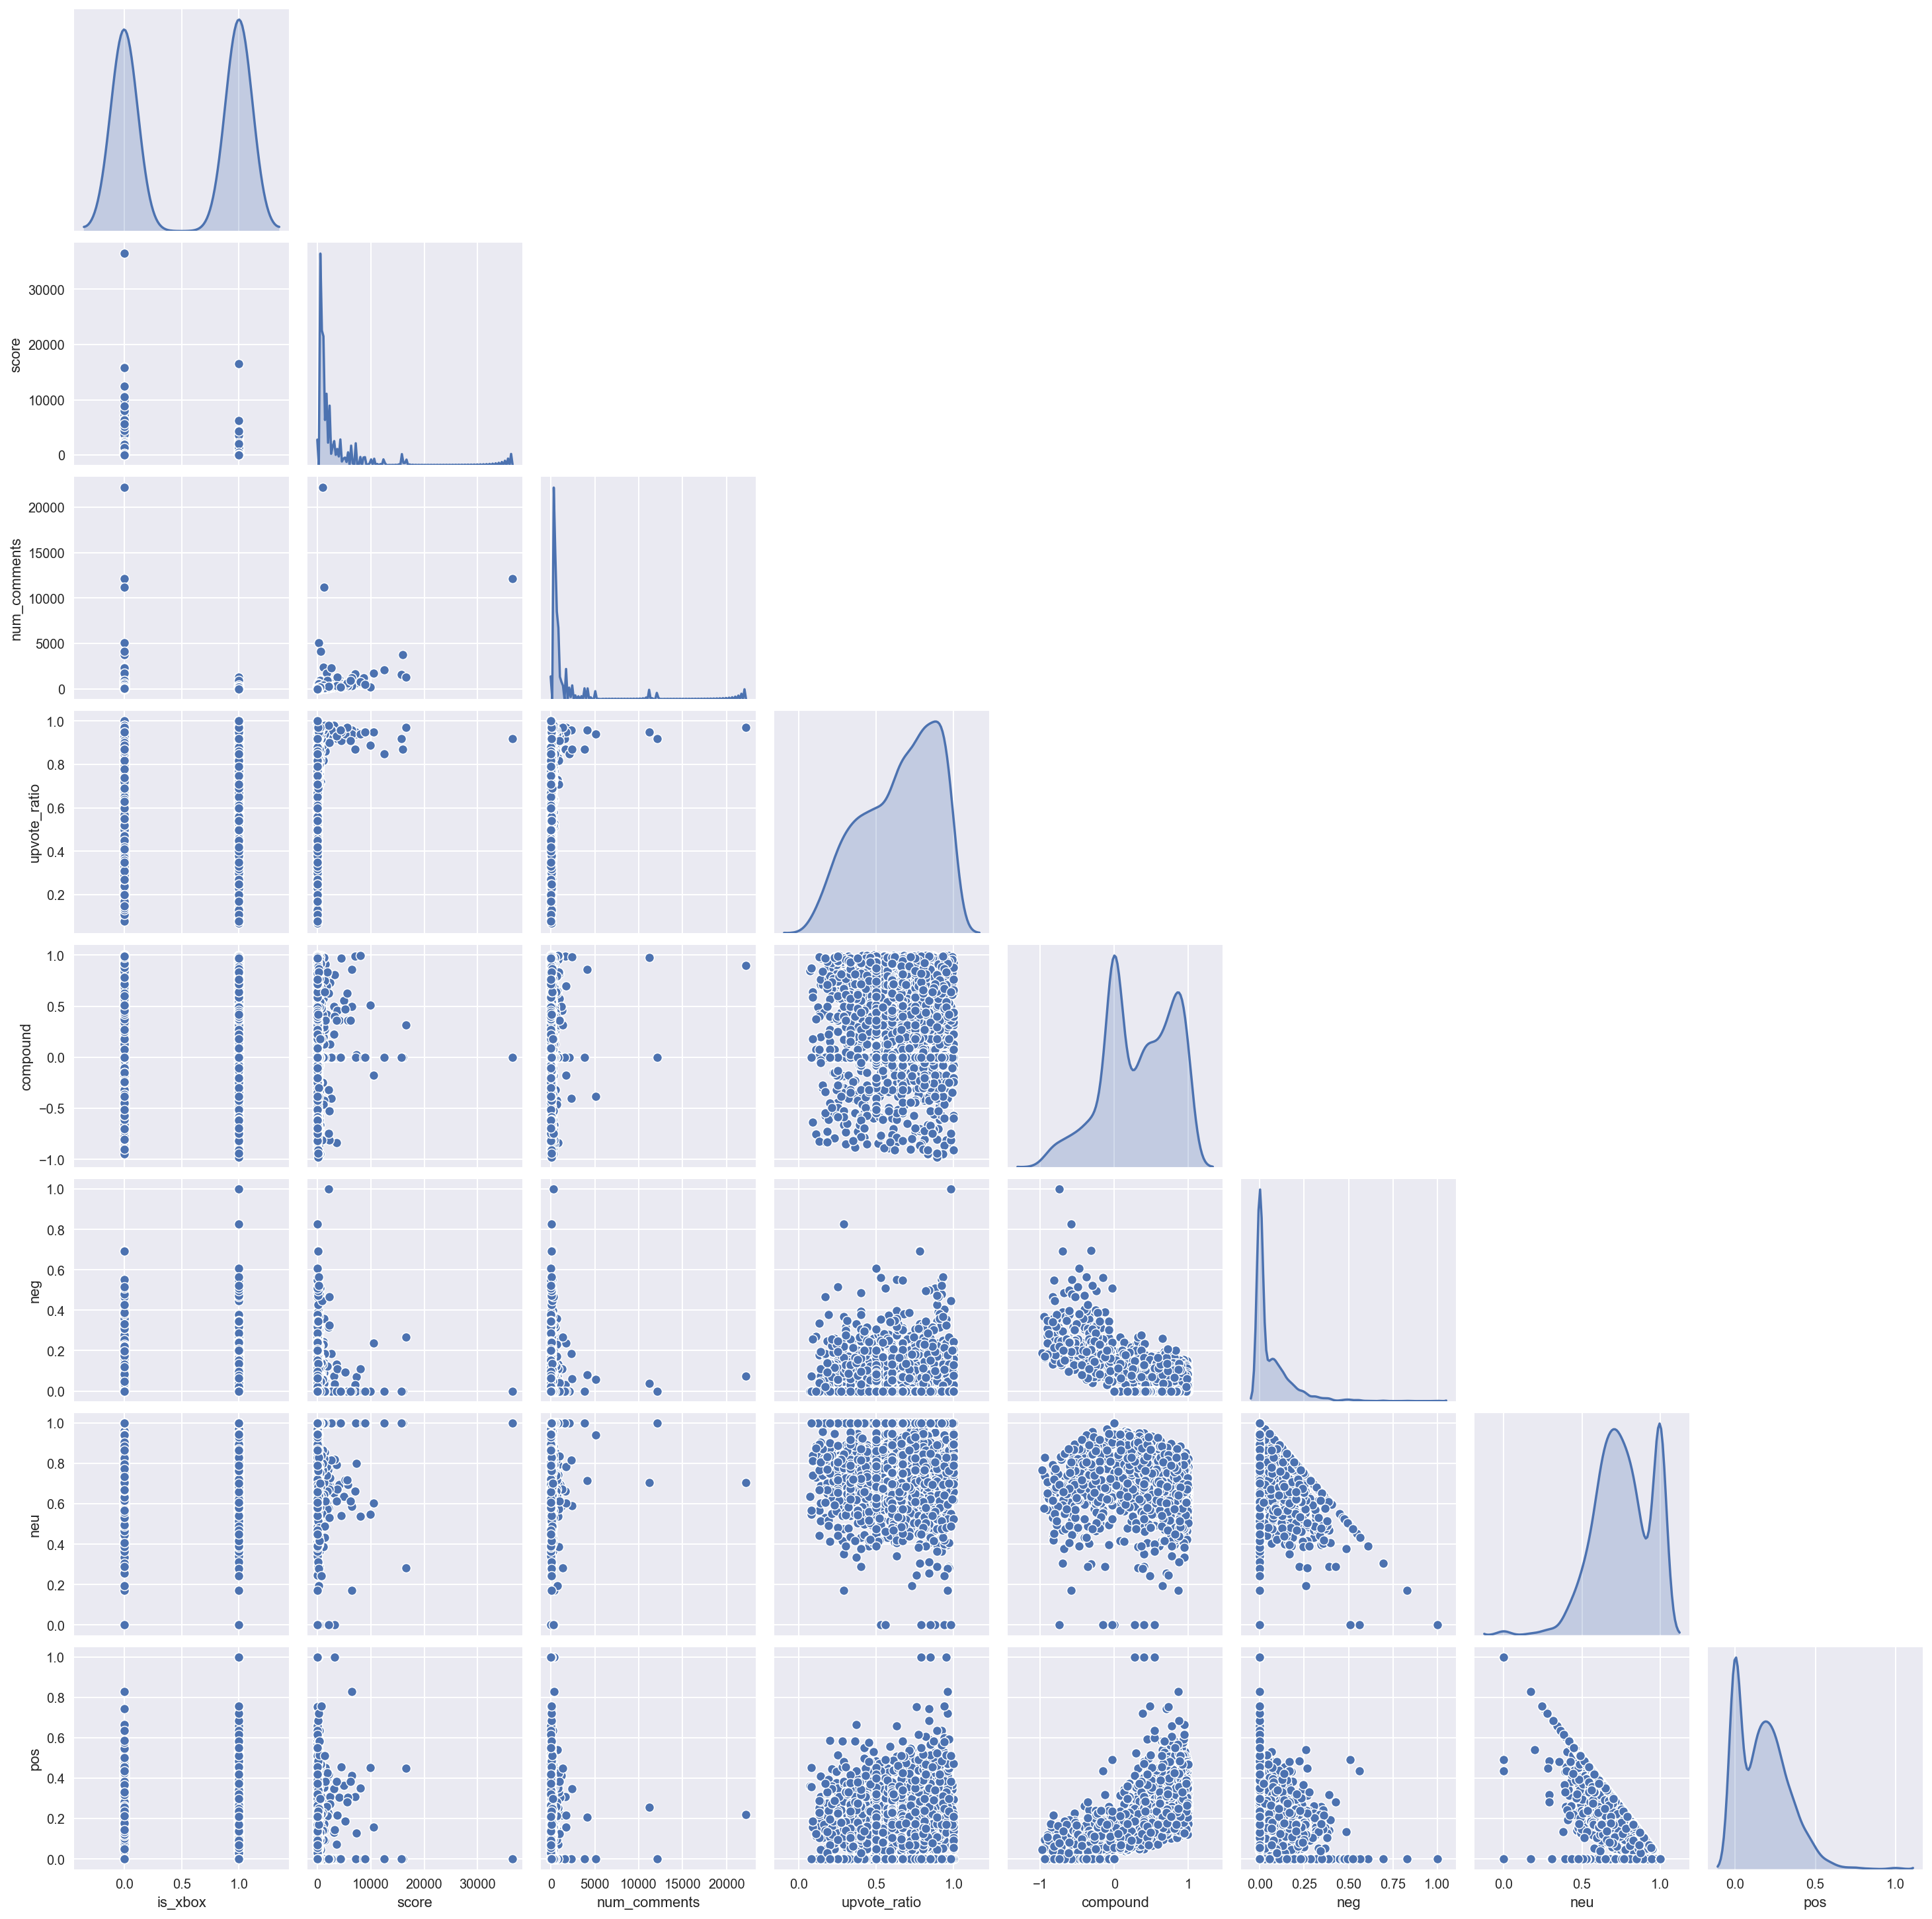

In [111]:
# run pairplot to have a quick understanding to see if there is any interesting co-relation
sns.pairplot(ps5_xboxseriesx_sentiment,kind ='scatter',diag_kind='kde', corner=True);
# No co-relation found

# Conclusions and Recommendations

## Conclusion

**From the results from this technical report, our stakeholders are now able to:**

- Use predictive modeling to best predict which subreddit a post came from.
    - This is done by comparing the performance of all models.
    - The best model is Logistic Regression model with CounterVectorizer because the train and test score is closest to each other. 
    - We can predict with an accuracy of about 88.7% where a given post came from.
    - From exploratory data analysis and the study of our coefficients generated by our model, we have found out the important predictive words for r/XboxSeriesX subreddit are 'xbox', 'series', 'microsoft', 'order', 'pre' and 'ps5', 'sony', 'ps4', 'playstation', 'soul' for r/PS5. These words were most able in differentiating our two chosen subreddits.
    - Paired with the knowledge of how these words associate with the subreddits, Data Scientiests in Reddit can make use of the model to trace posts with missing post labels back to their respective subreddit.
    - This can prevent lost of Reddit users and advertising customers caused by the server system glitch.

Technique of model can apply to other scope example, identify spam emails, automate CRM tasks based on topic matching, recommending similar articles to readers.

## Recommendation

Areas for Reddit Data Scientists' expansion and future exploration:
- moving forward, the model can be continuously improved by introducing more new data to it. Model accuracy and other metrics can be improved if more words were introduced. Hence better predictions for Reddit Data Scientist and their users/advertising customers.
- data from other subreddits can also be added to expand the model to not limited just to r/PS5 and r/XboxSeriesX use. The model can be applied to all the subreddits, eventually making classification predictions for the entire Reddit's posts in the future.

Other recommendations for Reddit Data Scientist to improve model for better accuracy and predictions for their users and advertising customers:
- try to explore other models eg Random Forest, Gradient Descent and SVM
- remove more overlapping words such as 'luanch' and 'console'
- explore comment texts
- Use ensemble modeling methods like sklearn’s VotingClassifier to improve accuracy
- Further explore if there is other ways to detect sentiment of the posts as that could bring revenue for advertisments.
- Spend more time on existing features webscraped eg study relationship of number of comments, length of words, scores, upvote_ratio on classification accuracy of a post

Areas for web developers for improvement:
- Combined two similar subreddits into 1 to reduce complexity and less classification errors.

## Sources and References

[Reddit API rules](urlhttps://github.com/reddit-archive/reddit/wiki/API#rules)